<span style="color:green; font-size:50px; font-weight:bold;">SOM FFN - VLIZ</span>

In [ ]:
############################################################################################
####                                                                                    ####
####    NAME         : SOM_FFN.py                                                       ####
####    EDITED       : Soren Berger             MPI-M       soren.berger@mpimet.mpg.de  ####
####                   Daniel Burt              VLIZ        daniel.burt@vliz.be         ####
####                   Arianna Olivelli         VLIZ        arianna.olivelli@vliz.be    ####
####                   Maurie Keppens           VLIZ        maurie.keppens@vliz.be      ####
####    LAST EDIT    : 08/09/25                                                         ####
####    DESCRIPTION  : This Python implementation is under development within the       ####
####                   Past, Present and Future Marine Climate Change Group of the      ####
####                   Flanders Marine Institute (VLIZ), Belgium.                       ####
####                                                                                    ####
####                   Class file for running Self-Organising Map component of          ####
####                   SOM-FFN method based on the MATLAB implementation of Peter       ####
####                   Landschuetzer and originally described in:                       ####
####                    -  Landschuetzer et al. (2013) Biogeosciences                   ####
####                                                                                    ####
####    DEPENDENCIES : Python 3.12.3                                                    ####
####                    - CartoPy 0.22.0                                                ####
####                    - MatPlotLib 3.6.3                                              ####
####                    - MiniSom 2.3.3 (https://github.com/JustGlowing/minisom)        ####
####                    - NumPy 1.26.4                                                  ####
####                    - SciPy 1.11.4                                                  ####
####                    - Xarray 2024.2.0                                               ####
####                                                                                    ####
####                                                                                    ####
############################################################################################

In [2]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import glob
pd.set_option('display.max_colwidth',100)
import joblib
import pickle
import csv

# machine learning libraries
import cartopy as cr
import matplotlib.ticker as tick
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
!pip install minisom
import minisom
import scipy as sp
import time
import warnings
import xarray as xr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
import gsw

# Python file with supporting functions
import residual_utils as supporting_functions

import gcsfs
fs = gcsfs.GCSFileSystem()

ModuleNotFoundError: No module named 'keras'

<span style="color:hotpink; font-size:40px; font-weight:bold;">Setting date range</span>

In [70]:
# Define date range
date_range_start = '1982-02-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')

init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

<span style="color:hotpink; font-size:40px; font-weight:bold;">Setting paths</span>

<span style="color:lightblue; font-size:30px; font-weight:bold;">Paths</span>

In [78]:
### set paths ###

your_username = "mauriekeppens" # leap pangeo username, for bucket. should be your github username

### paths for loading: ###

# where machine learning inputs are saved
# MLinputs_path = f"gs://leap-persistent/{your_username}" -> change later when I have ran all dataframes
MLinputs_path_abby = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs"
ensemble_dir_abby = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members'

path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

#########################################

### paths for saving: ###

#metrics_output_dir = f'{output_dir_FFN}/metrics' # where to save performance metrics
#test_perform_fname = f"{metrics_output_dir}/SOMFFN_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
#unseen_perform_fname = f"{metrics_output_dir}/SOMFFN_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

#SOMFFN_model_save_dir = f'{output_dir_FFN}/saved_models_{init_date}-{fin_date}' # where to save .json model file

xgb_data_dir = f"gs://leap-persistent/{your_username}/Ensemble_Testbed/01_ML_inputs" 

#########################################
jobs = 30

<span style="color:hotpink; font-size:40px; font-weight:bold;">Features and Target Variable</span>

In [55]:
### features for the SOM provinces determination:
features_sel_SOM = ['sst','sss','chl_log','mld_log','xco2'] 

### features for the SOM provinces determination:
features_sel_FFN = ['sst','sss','chl_log','mld_log','xco2'] 

### the target variable we reconstruct:
target_sel = ['spco2'] # the actual pCO2

# features masks
features_masks = ['net_mask', 'socat_mask']

# put features together:
features_select = ['sst','sss','chl_log','mld_log','xco2','spco2', 'net_mask', 'socat_mask'] 

<span style="color:hotpink; font-size:40px; font-weight:bold;">Create SOM Provinces</span>

<span style="color:lightblue; font-size:30px; font-weight:bold;"> Saving SOM paths</span>

In [56]:
# paths of the SOM part
output_dir_SOM = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM' # where to save machine learning results -> in the SOM of the SOMFFN
output_dir_SOM_fig = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/Figures' # where to save the ML results figures of the SOM

<span style="color:lightblue; font-size:30px; font-weight:bold;">Loading Variables</span>

In [20]:
ensembles = []
mems_dict = {}

# list of all ensembles in that ensemble_dir
for ens_path in fs.ls(MLinputs_path_abby):
    ens_name = ens_path.split("/")[-1]
    ensembles.append(ens_name)
    
    members = []
    for mem_path in fs.ls(ens_path):
        mem_name = mem_path.split("/")[-1]

        # check if the member has an ML input dataframe
        files = fs.ls(mem_path)
        ml_files = [f for f in files if f.endswith(".pkl") and "MLinput" in f]

        if ml_files:  # only keep if MLinput exists
            members.append(mem_name)

    if members: 
        mems_dict[ens_name] = members

# ---- Printing results ----
print("Ensembles found (with MLinputs):")
print(ensembles)

print("\nMembers per ensemble:")
total_members = 0
for ens, members in mems_dict.items():
    print(f"{ens}: {members} ({len(members)} members)")
    total_members += len(members)

print(f"\nTotal number of members across all ensembles: {total_members}")

Ensembles found (with MLinputs):
['ACCESS-ESM1-5', 'CESM2', 'CESM2-WACCM', 'CMCC-ESM2', 'CanESM5', 'CanESM5-CanOE', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'UKESM1-0-LL']

Members per ensemble:
ACCESS-ESM1-5: ['member_r4i1p1f1', 'member_r5i1p1f1'] (2 members)
CESM2: ['member_r10i1p1f1', 'member_r11i1p1f1', 'member_r4i1p1f1'] (3 members)
CESM2-WACCM: ['member_r1i1p1f1', 'member_r2i1p1f1', 'member_r3i1p1f1'] (3 members)
CMCC-ESM2: ['member_r1i1p1f1'] (1 members)
CanESM5: ['member_r10i1p2f1', 'member_r1i1p1f1', 'member_r1i1p2f1', 'member_r2i1p1f1', 'member_r2i1p2f1', 'member_r3i1p1f1', 'member_r3i1p2f1', 'member_r4i1p1f1', 'member_r4i1p2f1', 'member_r5i1p1f1', 'member_r5i1p2f1', 'member_r6i1p1f1', 'member_r6i1p2f1', 'member_r7i1p1f1', 'member_r7i1p2f1', 'member_r8i1p1f1', 'member_r8i1p2f1', 'member_r9i1p2f1'] (18 members)
CanESM5-CanOE: ['member_r1i1p2f1', 'member_r2i1p2f1', 'member_r3i1p2f1'] (3 members)
GFDL-ESM4: ['member_r1i1p1f1'] (1 members)
MPI-ESM1-2-LR: ['member_r11i1p1f1', 'member_r12i1p1

In [72]:
### See the structure of the input data

import pickle
import os

all_data = {}

print("Loading MLinput file for the first ensemble and member only - to see the structure of the input data \n")

# Get the first ensemble and its first member
first_ens = list(mems_dict.keys())[0]
first_mem = mems_dict[first_ens][0]

member_short = first_mem.split('member_')[1]
pkl_file = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs/{first_ens}/{first_mem}/MLinput_{first_ens}_{member_short}_mon_1x1_{init_date}_{fin_date}.pkl"

print(f"Processing first ensemble: {first_ens}")
print(f"  First member: {first_mem}")

if fs.exists(pkl_file):
    print(f"    Loading file: {pkl_file}")
    with fs.open(pkl_file, 'rb') as f:
        data = pickle.load(f)

    # Inspect the loaded data
    if hasattr(data, 'shape'):
        print(f"    Loaded data shape: {data.shape}")
        # Check if it has columns (likely a DataFrame)
        if hasattr(data, 'columns'):
            print("    Feature names:")
            print(list(data.columns))
    elif hasattr(data, 'head'):
        print(f"    Loaded pandas DataFrame (head):\n{data.head()}")
        print("    Feature names:")
        print(list(data.columns))
    else:
        print(f"    Loaded data type: {type(data)}")

Loading MLinput file for the first ensemble and member only - to see the structure of the input data 

Processing first ensemble: ACCESS-ESM1-5
  First member: member_r4i1p1f1
    Loading file: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs/ACCESS-ESM1-5/member_r4i1p1f1/MLinput_ACCESS-ESM1-5_r4i1p1f1_mon_1x1_198202_202312.pkl
    Loaded data shape: (32594400, 27)
    Feature names:
['key_0', 'sss', 'sst', 'mld', 'chl', 'pco2_residual', 'spco2', 'socat_mask', 'chl_sat', 'mld_log', 'mld_anom', 'mld_log_anom', 'mld_clim', 'mld_clim_log', 'chl_log', 'chl_log_anom', 'chl_sat_log', 'chl_sat_anom', 'sss_anom', 'sst_anom', 'T0', 'T1', 'A', 'B', 'C', 'net_mask', 'xco2']


<span style="color:lightblue; font-size:30px; font-weight:bold;">Make SOM class</span>

In [8]:
####  DEFINE CLASS
class SelfOrganizingMap:

    """
        NAME        : SelfOrganizingMap
        DESCRIPTION : Python class containing functions related to the
                      Self-Organizing Map (SOM) component of the SOM-FFN method.
        FUNCTIONS   :
            - LoadInputDataMember           : Loads ML input data for a single member and reshapes into 3D arrays (time x lat x lon)
            - CalculateMeanMonths           : Computes the mean annual cycle per grid point (12 months)
            - ReshapeRearrange              : Collapses input features into 2D arrays for SOM training, removes NaNs
            - IdentifyProvinces             : Initializes and trains SOM; reshapes winning neurons into 
                                              [month, lat, lon] provinces array
            - WriteProvinces                : Saves provinces to Zarr format (local or GCS)
            - PlotProvinces                 : Dispatcher for different plot types:
                                                'modal'             : Modal province for a single member
                                                'variability'       : Number of unique provinces per grid cell (single member)
                                                'monthly'           : Monthly province maps
                                                'ensemble-variability': Grid of variability maps across members
                                                'ensemble-modal'     : Grid of modal province maps across members
            - PlotModalProvince             : Plots modal province for a single member
            - PlotModalProvinceEnsemble     : Plots modal provinces for all members of an ensemble in a grid
            - PlotProvinceVariability       : Plots variability map (unique provinces) for a single member
            - PlotProvinceVariabilityEnsemble : Plots variability maps for all members of an ensemble in a grid
            - PlotProvincesMonthly          : Plots all 12 monthly province maps
    """

    def LoadInputDataMember(self, pkl_file, features_sel_SOM=None):
        """
        Load MLinput data for a single member and convert to 3D arrays (time x lat x lon).

        Parameters
        ----------
        all_data : dict
            Dictionary of MLinput data loaded from pickle files, structured as all_data[ensemble][member].
        ensemble : str, optional
            Name of the ensemble to load. If None, loads the first ensemble.
        member : str, optional
            Name of the member to load. If None, loads the first member in the ensemble.
        """

        if not fs.exists(pkl_file):
            print(f"File not found: {pkl_file}")
            return

        print(f"Loading MLinput file: {pkl_file}")
        with fs.open(pkl_file, 'rb') as f:
            df = pickle.load(f)

        # If feature selection provided, filter the dataframe
        if features_sel_SOM is not None:
            df = df[features_sel_SOM]
        
        # Determine dimensions
        lat_len = 180
        lon_len = 360
        n_time = df.shape[0] // (lat_len * lon_len)

        # Store basic metadata
        self.n_time = n_time
        self.lat_values = np.linspace(-89.5, 89.5, lat_len, dtype=np.float32)
        self.lon_values = np.linspace(-179.5, 179.5, lon_len, dtype=np.float32)

        # Create dictionary of 3D arrays
        self.input_array_dict = {}
        for feature in df.columns:
            arr = df[feature].values.reshape(n_time, lat_len, lon_len) # reshape the input data into time x lat x lon dimensions
            self.input_array_dict[feature] = arr

        # Add lat/lon arrays
        self.input_array_dict['lat'] = np.tile(np.linspace(-89.5, 89.5, lat_len, dtype=np.float32), (lon_len, 1)).T
        self.input_array_dict['lon'] = np.tile(np.linspace(-179.5, 179.5, lon_len, dtype=np.float32), (lat_len, 1))

        print("Input arrays loaded with shape per feature:")
        for k, v in self.input_array_dict.items():
            print(f"  {k}: {v.shape}")
        print("Feature names used:")
        print(list(self.input_array_dict.keys()))

    def CalculateMeanMonths(self):
        """
        Calculate the mean of months of input data for entire time period (all years)
        to produce a mean annual cycle for every latitude and longitude (every grid point).
        """

        if not hasattr(self, 'input_array_dict'):
            print('ERROR: Input data not found. Call LoadInputDataMember first.')
            return

        self.annual_cycle_dict = {}

        # evaluate input variable
        for feature in self.input_array_dict.keys():
            if feature in ['lat', 'lon']: # we dont want to look at the input variables lat and lon, we don't want to average those two
                continue

            arr = self.input_array_dict[feature]
            n_time, lat_len, lon_len = arr.shape
            self.annual_cycle_dict[feature] = np.empty((12, lat_len, lon_len), dtype='float32')

            for month in range(12):
                month_slice = arr[month::12, :, :]
                            # ::12 picks months 0, 12, 24 for january; 1, 13,25 for february etc.
                # Check for any lat-lon points that are all NaN over the years
                #all_nan_mask = np.all(np.isnan(month_slice), axis=0)  # shape (lat, lon)
                #if np.any(all_nan_mask):
                #    print(f"WARNING: Feature '{feature}', month {month+1} has NaN at {np.sum(all_nan_mask)} grid points")
 
                self.annual_cycle_dict[feature][month, :, :] = np.nanmean(month_slice, axis=0) # input data was put to time x lat x lon

            # RESULT: self.annual_cycle_dict[input_variable] contains a mean annual cycle (12 months) for each lat/lon point.

    def ReshapeRearrange(self):
        """
        Collapse input features into 2D array for SOM training (samples x features).
        Removes NaN values across any feature.
        """

        if not hasattr(self, 'annual_cycle_dict'):
            print('ERROR: Annual cycle not found. Call CalculateMeanMonths first.')
            return

        feature_arrays = []
        valid_masks = []

        for feature in self.annual_cycle_dict.keys():
            arr = self.annual_cycle_dict[feature].reshape(-1, 1)
            feature_arrays.append(arr)
            valid_masks.append(np.isnan(arr))

        # create boolean NaN index from all collapsed NumPy arrays with bitwise OR operator
        self.arr_nan_index = np.ravel(np.logical_or.reduce(valid_masks))
        # remove NaNs from NumPy arrays and transpose to generate input for SOM algorithm
        arr_som_input_full = np.column_stack(feature_arrays)
        self.arr_som_input = arr_som_input_full[~self.arr_nan_index]
            # array with Rows = number of grid cells × 12 months
            # Columns = number of features
        print(f"SOM input array prepared with shape: {self.arr_som_input.shape}")

        print(f"Feature arrays shapes: {[arr.shape for arr in feature_arrays]}")
        print(f"NaN mask shape: {self.arr_nan_index.shape}, number of True (NaN) entries: {np.sum(self.arr_nan_index)}")
        print(f"SOM input shape after removing NaNs: {self.arr_som_input.shape}")

    def IdentifyProvinces(self, neuron_map_length=4, neuron_map_height=4,
                          som_sigma=2.0, som_learning_rate=0.5,
                          som_neighbourhood_function = 'gaussian',
                          som_topology = 'hexagonal',
                          number_of_epochs=int(1e6),
                          net_mask=None):
            
        """
        Train SOM and assign provinces, optionally masking outside the net_mask.
        net_mask : 3D array (time x lat x lon) with True/False indicating valid grid cells

        ARGUMENTS   : neuron_map_length               (int)     defines the length of the map neuron layer
                      neuron_map_height               (int)     defines the height of the map neuron layer
                      som_sigma                     (float)     defines the neighbourhood radius
                      som_learning_rate             (float)     ...
                      som_neighbourhood_function    (string)    ...
                      som_topology                  (string)    initial neuron topology of map
                      number_of_epochs              (int)       defines the number of times the neurons are presented with the input vectors
        """

        if not hasattr(self, 'arr_som_input'):
            print("ERROR: SOM input not prepared. Call ReshapeRearrange first.")
            return

        # initialise Self Organising Map algorithm (creating a SOM)
        self.som_algorithm = minisom.MiniSom(
            x=neuron_map_length,  # SOM length in neurons, number of neurons along the SOM's x-axis (columns); controls the map's horizontal size
            y=neuron_map_height,  # SOM height in neurons, Number of neurons along the SOM’s y-axis (rows). This controls the map’s vertical size.
            input_len=self.arr_som_input.shape[1], # number of features per sample; for example if 5 environmental variables, then this is 5
            sigma=som_sigma,      # neighbourhood radius; how far a neuron’s influence spreads to its neighbors during training. Larger values mean broader influence at the start.
            learning_rate=som_learning_rate, # How fast the neurons update their weights when learning. Higher values = bigger changes per step.
            neighborhood_function = som_neighbourhood_function, # Shape of the influence area around the best matching unit (BMU). Common choice: 'gaussian'.
            topology = som_topology, # 	Shape of the neuron grid — 'rectangular' or 'hexagonal'. Changes how neighbors are determined.
            random_seed=0)

        # A Self-Organizing Map (SOM) is like a 2D grid of “neurons” (nodes), each having a weight vector the same size as your input feature vectors.
        # During training, the SOM learns to organize similar inputs close together on the grid — it’s an unsupervised clustering method.
        # minisom.MiniSom(...) is being called to create such a grid before training.
        # so this creates a grid of neuron_map_length × neuron_map_height neurons; Each neuron has a weight vector of length input_len
        # Initially, these weights are random. During training, they will move to represent different “typical” patterns in your data.

        # perform first round of training of Self Organising Map Algorithm
        self.som_algorithm.train_random(self.arr_som_input, number_of_epochs)
        print("SOM training completed.")
        # self.arr_som_input → a 2D array where each row is a feature vector (e.g., environmental variables for a grid point in a specific month).
        # train_random → picks samples in random order, finds the best matching neuron (BMU), and updates it (and its neighbors) so its weights better match the sample.
        # After this step, the SOM neurons’ weight vectors represent “typical” patterns in the dataset.
        # That’s the training step where the BMU (best matching neuron) and its neighbors get their weights adjusted toward the input vector.

        # --- Assign winning neurons ---
        # allocate winning map neuron two-dimensional location to array as [x, y]
        winning_neurons_position = np.array([self.som_algorithm.winner(x) for x in self.arr_som_input])
        # For each input vector: (so each row of arr_som_input is a vector that has the values of all environmental variables (and this for a specific month - lat - lon combination)
            # winner(x) returns (row, col) → the coordinates of the BMU in the SOM grid. so for each input vector we define the best matching neuron and it gives back the coordinates of that neuron
            # Example: (2, 1) means “3rd row, 2nd column neuron was the closest match”.

        # so if we have neuron_map_length = 4 and neuron_map_height = 4 -> we can choose from 16 neurons for the best matching neuron 

        # reformat two-dimensional position tuple to one-dimensional index
        self.arr_winning_neurons = winning_neurons_position[:, 0] * neuron_map_length + winning_neurons_position[:, 1]
        # Flattens the SOM grid coordinates into a single integer cluster ID.
        # It converts the neuron coordinates in the SOM from 2D (row, column) into a unique, simple 1D ID for easier process
        
        # --- Fill provinces correctly ---
        # number of months, lat, lon
        # eerst reshape naar (months, lon, lat)
        flat_provinces = np.full(self.arr_nan_index.shape, np.nan)
        flat_provinces[~self.arr_nan_index] = self.arr_winning_neurons
        provinces = flat_provinces.reshape(12, self.lon_values.size, self.lat_values.size).transpose(0, 2, 1)

        # --- Apply net_mask if provided ---
        if net_mask is not None:
            if net_mask.shape != provinces.shape:
                raise ValueError(f"net_mask shape {net_mask.shape} does not match provinces shape {provinces.shape}")
            provinces[~net_mask] = np.nan  # mask out invalid locations

        self.provinces = provinces

    def WriteProvinces(self, output_dir, ens, member):
        """
        Write identified province map directly to Zarr format.
        Supports local paths or GCS (gs://), with ENS/member folder structure.

        Parameters
        ----------
        output_dir : str
            Base output directory (local or gs://)
        ens : str
            Earth System Model name
        member : str
            Member index (e.g. 'r1i1p1f1')
        """

        # --- Sanity checks ---
        if len(self.input_array_dict) == 0:
            raise ValueError('Input data not found. Call "LoadInputData" first.')
        if not hasattr(self, 'provinces'):
            raise ValueError('Provinces array not found. Call "IdentifyProvinces" first.')

        # --- Create ENS/member folder path ---
        zarr_dir = f"{output_dir}/{ens}/{member}"

        # --- Create Xarray DataArray ---
        DA_out = xr.DataArray(
            self.provinces,
            dims=['time','lat','lon'],
            coords={
                'time': range(self.provinces.shape[0]),
                'lat': np.linspace(-89.5, 89.5, 180, dtype=np.float32),
                'lon': np.linspace(-179.5, 179.5, 360, dtype=np.float32)
            },
            name='provinces')

        # --- Print structure ---
        print("Provinces shape:", DA_out.shape)
        # Summary statistics
        print("Number of unique provinces:", len(np.unique(DA_out.values[~np.isnan(DA_out.values)])))

        # --- Write directly to Zarr ---
        DA_out.to_zarr(f"{zarr_dir}/som-output_provinces.zarr", mode='w')
        print(f"Provinces saved to {zarr_dir}/som-output_provinces.zarr")

    def PlotProvinces(self, plot_type='modal', fpath_output_plot=None, som_dict=None, ens=None):
        """
        Dispatcher for plotting different types of province maps.

        ARGUMENTS:
        ----------
        plot_type : str
            Which plot function to call. Options: 'modal', 'variability', 'monthly', 
            'ensemble-variability', 'ensemble-modal'.
        fpath_output_plot : str, optional
            Optional file path to save the plot.
        som_dict : dict, optional
            Dictionary of SOM objects if plotting ensemble maps.
        ens : str, optional
            Ensemble name if plotting ensemble maps.
        """
        if not hasattr(self, 'provinces') and plot_type not in ['ensemble-variability', 'ensemble-modal']:
            raise ValueError('Provinces array not found. Call "IdentifyProvinces" first.')

        if fpath_output_plot is None:
            self.fpath_output_plot = f"./output-plots/som-output_provinces_{plot_type}.png"
        else:
            self.fpath_output_plot = fpath_output_plot

        if plot_type == 'modal':
            self.PlotModalProvince(fpath_output_plot=self.fpath_output_plot)
        elif plot_type == 'variability':
            self.PlotProvinceVariability(fpath_output_plot=self.fpath_output_plot)
        elif plot_type == 'monthly':
            self.PlotProvincesMonthly(fpath_output_plot=self.fpath_output_plot)
        elif plot_type == 'ensemble-variability':
            if som_dict is None or ens is None:
                raise ValueError("For 'ensemble-variability', both 'som_dict' and 'ens' must be provided.")
            self.PlotProvinceVariabilityEnsemble(som_dict=som_dict, ens=ens, fpath_output_plot=self.fpath_output_plot)
        elif plot_type == 'ensemble-modal':
            if som_dict is None or ens is None:
                raise ValueError("For 'ensemble-modal', both 'som_dict' and 'ens' must be provided.")
            self.PlotModalProvinceEnsemble(som_dict=som_dict, ens=ens, fpath_output_plot=self.fpath_output_plot)
        else:
            raise ValueError(
                "Plot type not recognised. Valid options: 'modal', 'variability', 'monthly', "
                "'ensemble-variability', 'ensemble-modal'.")

    def PlotModalProvince(self, ens, member, output_dir_SOM_fig=None, cmap='tab20'):
        """
        Plot the modal province (most frequently occurring province across months)
        for a single member, masking land according to net_mask.

        Parameters
        ----------
        ens : str
            Ensemble/model name
        member : str
            Member name/ID
        output_dir_SOM_fig : str, optional
            Base output directory to save the figure.
        cmap : str, optional
            Matplotlib colormap name for provinces.
        """

        import cartopy.crs as ccrs
        from matplotlib.colors import ListedColormap

        if not hasattr(self, 'provinces'):
            raise ValueError("Provinces array not found. Run IdentifyProvinces first.")

        provinces_data = self.provinces.copy()
        months, lat_len, lon_len = provinces_data.shape
        provinces_mode = np.full((lat_len, lon_len), np.nan)

        # --- Compute modal province per grid cell ---
        for i in range(lat_len):
            for j in range(lon_len):
                cell_values = provinces_data[:, i, j]
                if np.all(np.isnan(cell_values)):
                    continue
                vals_nonan = cell_values[~np.isnan(cell_values)]
                uniq, counts = np.unique(vals_nonan, return_counts=True)
                provinces_mode[i, j] = uniq[np.argmax(counts)]

        # --- Define discrete colormap ---
        n_provinces = int(np.nanmax(provinces_mode)) + 1 if np.any(~np.isnan(provinces_mode)) else 1
        cmap_discrete = plt.cm.get_cmap(cmap, n_provinces)
        colors = cmap_discrete(np.arange(n_provinces))
        cmap_discrete = ListedColormap(colors)

        # --- Plot ---
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})
        data_crs = ccrs.PlateCarree()

        im = ax.pcolormesh(
            self.lon_values,
            self.lat_values,
            provinces_mode,
            transform=data_crs,
            cmap=cmap_discrete,
            vmin=0,
            vmax=n_provinces - 1,
            shading='auto')

        # --- Gridlines and coastlines ---
        gl = ax.gridlines(linewidth=0.5, color='k')
        gl.xlocator = tick.FixedLocator(range(-180, 181, 30))
        gl.ylocator = tick.FixedLocator(range(-90, 91, 15))
        ax.coastlines()

        # --- Colorbar ---
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.03, pad=0.02, aspect=80, shrink=0.70)
        cbar.set_ticks(np.arange(0, n_provinces))
        cbar.set_ticklabels([str(i) for i in range(n_provinces)])
        cbar.set_label("Modal Province", fontsize=20)
        cbar.ax.tick_params(labelsize=16)

        # --- Title ---
        ax.set_title(f"{ens} / {member} — Modal Province Map", fontsize=16)
    
        # --- Save figure locally ---
        if output_dir_SOM_fig is None:
            output_dir_SOM_fig = "./Figures"

        save_dir = os.path.join(output_dir_SOM_fig, "SOM", "Modal_Provinces", "Each_Member")
        os.makedirs(save_dir, exist_ok=True)
        fpath_output_plot = os.path.join(save_dir, f"modal_province_{ens}_{member}.png")

        plt.savefig(fpath_output_plot, bbox_inches='tight', dpi=150)
        print(f"Saved figure to {fpath_output_plot}")
        plt.show()

    def PlotModalProvinceEnsemble(self, som_dict, ens, output_dir_SOM_fig=None, max_cols=5, cmap="tab20"):
        """
        Plot the modal province (most frequently occurring province across months)
        for all members of a given ensemble in a grid of subplots.

        Parameters
        ----------
        som_dict : dict
            Dictionary of SOM objects. Can be either:
            - Full all_som_dicts: som_dict[ensemble][member] = SOM object
            - Per-ensemble dict: som_dict[member] = SOM object
        ens : str
            Ensemble name to plot.
        output_dir_SOM_fig : str, optional
            Base directory to save figures. Defaults to ./Figures if None.
        max_cols : int, optional
            Maximum number of subplot columns. Default = 5.
        cmap : str, optional
            Matplotlib colormap to use (discrete). Default = "tab20".
        """
        import os
        import matplotlib.pyplot as plt
        import numpy as np
        import cartopy.crs as ccrs
        from matplotlib.colors import ListedColormap

        # Determine if som_dict is per-ensemble or all_ensembles
        first_key = list(som_dict.keys())[0]
        if isinstance(som_dict[first_key], dict):
            # full all_som_dicts
            if ens is None:
                raise ValueError("For full all_som_dicts, you must provide the ensemble name 'ens'.")
            members_dict = som_dict.get(ens, {})
            if len(members_dict) == 0:
                raise ValueError(f"No members found for ensemble '{ens}'.")
        else:
            # per-ensemble dict
            members_dict = som_dict
            if ens is None:
                ens = "Unknown_Ensemble"

        n_members = len(members_dict)

        # --- Grid layout ---
        n_cols = min(n_members, max_cols)
        n_rows = int(np.ceil(n_members / n_cols))

        fig, axs = plt.subplots(
            n_rows, n_cols,
            figsize=(4 * n_cols, 3 * n_rows),
            subplot_kw={"projection": ccrs.Robinson()})

        fig.patch.set_facecolor("white")
        axs = np.array(axs).reshape(-1)

        im = None
        vmax_global = 0  # keep track for consistent colormap scaling

        # --- Loop over members ---
        for ax, (mem, som) in zip(axs, members_dict.items()):
            months, lat_len, lon_len = som.provinces.shape
            modal_map = np.full((lat_len, lon_len), np.nan)

            for i in range(lat_len):
                for j in range(lon_len):
                    cell_values = som.provinces[:, i, j]
                    if np.all(np.isnan(cell_values)):
                        continue
                    vals_nonan = cell_values[~np.isnan(cell_values)]
                    uniq, counts = np.unique(vals_nonan, return_counts=True)
                    modal_map[i, j] = uniq[np.argmax(counts)]

            n_neurons = int(np.nanmax(modal_map)) + 1 if np.any(~np.isnan(modal_map)) else 1
            vmax_global = max(vmax_global, n_neurons - 1)

            cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
            colors = cmap_discrete(np.arange(n_neurons))
            cmap_discrete = ListedColormap(colors)

            im = ax.pcolormesh(
                som.lon_values,
                som.lat_values,
                modal_map,
                transform=ccrs.PlateCarree(),
                cmap=cmap_discrete,
                vmin=0,
                vmax=max(n_neurons - 1, 1),
                shading="auto")

            ax.coastlines()
            ax.set_title(mem, fontsize=10)

        # --- Turn off unused subplots ---
        for ax in axs[n_members:]:
            ax.axis("off")

        # --- Single colorbar ---
        cbar = fig.colorbar(
            im, ax=axs[:n_members], orientation="horizontal",
            fraction=0.03, pad=0.05, aspect=80
        )
        cbar.set_label("Modal Province (Most Frequent)", fontsize=14)
        cbar.ax.tick_params(labelsize=12)

        plt.suptitle(f"{ens} — Modal Province Across Members", fontsize=16)

        # --- Save locally ---
        if output_dir_SOM_fig is None:
            output_dir_SOM_fig = "./Figures"

        save_dir = os.path.join(output_dir_SOM_fig, "SOM", "Modal_Provinces", "Ensemble")
        os.makedirs(save_dir, exist_ok=True)
        fpath_output_plot = os.path.join(save_dir, f"modal_province_{ens}_all_members.png")

        plt.savefig(fpath_output_plot, bbox_inches="tight", dpi=150)
        print(f"Saved figure to {fpath_output_plot}")
        plt.show()

    def CountUniqueProvinces(self):
        """
        Count number of unique provinces per grid cell across all months.
        Returns a 2D array of shape (lat, lon)
        """
        if not hasattr(self, 'provinces'):
            raise ValueError("Provinces array not found. Run IdentifyProvinces first.")

        # Check if there are any NaN values in the provinces array
        if np.isnan(som.provinces).any():
            print("There are NaN values in the provinces array")
        else:
            print("No NaN values in the provinces array")

        # For each grid cell, count number of unique provinces ignoring NaNs
        variability_map = np.full((180, 360), np.nan, dtype=float)  # float array initialized with NaN
        for i in range(180):
            for j in range(360):
                values = self.provinces[:, i, j]
                values = values[~np.isnan(values)]  # remove NaNs
                if len(values) > 0:
                    variability_map[i, j] = len(np.unique(values))
                # else leave as NaN
        return variability_map
        
    def PlotProvinceVariability(self, ens, member, output_dir_SOM_fig=None, cmap='tab20'):
        """
        Plot the variability of provinces across months for a single member,
        masking land according to net_mask and using discrete colors per province.
    
        Parameters
        ----------
        ens : str
            Ensemble/model name
        member : str
            Member name/ID
        fpath_output_plot : str, optional
            File path to save the plot.
        cmap : str, optional
            Matplotlib colormap name for provinces.
        """

        import cartopy.crs as ccrs
        from matplotlib.colors import ListedColormap

        if not hasattr(self, 'provinces'):
            raise ValueError("Provinces array not found. Run IdentifyProvinces first.")

        # --- Count unique provinces (land cells should be NaN) ---
        variability_map = self.CountUniqueProvinces()
        provinces_variability_vmax = int(np.nanmax(variability_map))

        # --- Set up colormap for provinces only ---
        cmap_discrete = plt.cm.get_cmap(cmap, provinces_variability_vmax)
        colors = cmap_discrete(np.arange(provinces_variability_vmax))
        cmap_discrete = ListedColormap(colors)

        # --- Plot ---
        fig, ax = plt.subplots(figsize=(12,6), subplot_kw={"projection": ccrs.Robinson()})
        data_crs = ccrs.PlateCarree()

        im = ax.pcolormesh(
            self.lon_values,
            self.lat_values,
            variability_map,
            transform=data_crs,
            cmap=cmap_discrete,
            vmin=1,
            vmax=provinces_variability_vmax,
            shading='auto'
        )

        # --- Gridlines and coastlines ---
        gl = ax.gridlines(linewidth=0.5, color='k')
        gl.xlocator = tick.FixedLocator(range(-180, 181, 30))
        gl.ylocator = tick.FixedLocator(range(-90, 91, 15))
        ax.coastlines()

        # --- Colorbar ---
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.03, pad=0.02, aspect=80, shrink=0.70)
        cbar.set_ticks(np.arange(1, provinces_variability_vmax + 1))
        cbar.set_ticklabels([str(i) for i in range(1, provinces_variability_vmax + 1)])
        cbar.set_label('Number of Provinces', fontsize=20)
        cbar.ax.tick_params(labelsize=16)

        # --- Title ---
        ax.set_title(f"{ens} / {member} — Province Variability Map", fontsize=16)

        # --- Save figure locally ---
        if output_dir_SOM_fig is None:
            output_dir_SOM_fig = "./Figures"

        save_dir = os.path.join(output_dir_SOM_fig, "SOM", "Count_Provinces", "Each_Member")
        os.makedirs(save_dir, exist_ok=True)
        fpath_output_plot = os.path.join(save_dir, f"count_unique_provinces_{ens}_{member}.png")
  
        plt.savefig(fpath_output_plot, bbox_inches='tight', dpi=150)
        print(f"Saved figure to {fpath_output_plot}")
        plt.show()

    def PlotProvinceVariabilityEnsemble(self, som_dict, ens, fpath_output_plot=None, max_cols=5):
        """
        Plot the spatial variability of provinces for all SOM members in an ensemble,
        using discrete colors and saving in a structured local folder.
    
        Parameters
        ----------
        som_dict : dict
            Dictionary of SOM objects. Can be either:
            - Full all_som_dicts: som_dict[ensemble][member] = SOM object
            - Per-ensemble dict: som_dict[member] = SOM object
        ens : str
            Ensemble name to plot.
        fpath_output_plot : str, optional
            Path to save the figure.
        max_cols : int, optional
            Maximum number of columns per subplot grid. Default is 5.
        """

        import os
        import cartopy.crs as ccrs
        from matplotlib.colors import ListedColormap

        # Determine if som_dict is per-ensemble or all_ensembles
        first_key = list(som_dict.keys())[0]
        if isinstance(som_dict[first_key], dict):
            # full all_som_dicts
            members_dict = som_dict.get(ens, {})
            if len(members_dict) == 0:
                raise ValueError(f"No members found for ensemble '{ens}'.")
        else:
            # per-ensemble dict
            members_dict = som_dict
            if ens is None:
                ens = "Unknown_Ensemble"
                    
        n_members = len(members_dict)

        # Determine grid shape
        n_cols = min(n_members, max_cols)
        n_rows = int(np.ceil(n_members / n_cols))

        fig, axs = plt.subplots(
            n_rows, n_cols,
            figsize=(4*n_cols, 3*n_rows),
            subplot_kw={'projection': ccrs.Robinson()})
        
        fig.patch.set_facecolor('white')
        axs = np.array(axs).reshape(-1)  # flatten in case of 1D

        # Compute maximum variability across all members for consistent colormap
        max_var = max([int(np.nanmax(som.CountUniqueProvinces())) for som in members_dict.values()])

        # Create discrete colormap
        cmap_discrete = plt.cm.get_cmap('tab20', max_var)
        colors = cmap_discrete(np.arange(max_var))
        cmap_discrete = ListedColormap(colors)

        # Plot each member
        for ax, (mem, som) in zip(axs, members_dict.items()):
            variability_map = som.CountUniqueProvinces()
            im = ax.pcolormesh(
                som.lon_values, som.lat_values, variability_map,
                transform=ccrs.PlateCarree(),
                cmap=cmap_discrete,
                vmin=1, vmax=max_var,
                shading='auto')
            ax.coastlines()
            ax.gridlines(draw_labels=True, linewidth=0.5, color='k')
            ax.set_title(mem, fontsize=10)

        # Turn off unused axes
        for ax in axs[n_members:]:
            ax.axis('off')

        # Single horizontal colorbar for all subplots
        cbar = fig.colorbar(
            im, ax=axs[:n_members], orientation='horizontal',
            fraction=0.03, pad=0.05
        )
        cbar.set_ticks(np.arange(1, max_var + 1))
        cbar.set_ticklabels([str(i) for i in range(1, max_var + 1)])
        cbar.set_label("Number of Unique Provinces (All Months)", fontsize=14)

        plt.suptitle(f"{ens} — Province Variability Across Members", fontsize=16)

        # Save figure locally in structured folder
        output_dir_SOM_fig = "./Figures"
        save_dir = os.path.join(output_dir_SOM_fig, "SOM", "Count_Provinces", "Ensemble")
        os.makedirs(save_dir, exist_ok=True)

        if fpath_output_plot is None:
            fpath_output_plot = os.path.join(save_dir, f"variability_{ens}_all_members.png")

        plt.savefig(fpath_output_plot, bbox_inches='tight', dpi=150)
        plt.show()
        print(f"Saved figure to {fpath_output_plot}")


    def PlotProvincesMonthly(self, ens=None, member=None, fpath_output_plot=None):
        """
        Plot all 12 monthly province maps with optional ESM/member in title.

        ARGUMENTS:
        ----------
        ens : str, optional
            Ensemble/model name.
        member : str, optional
            Member name/ID.
        fpath_output_plot : str, optional
            Path to save the figure. If None, uses default.
        """
        if not hasattr(self, 'provinces'):
            raise ValueError("Provinces not found. Run IdentifyProvinces first.")

        data_crs = ccrs.PlateCarree()
        # Create figure with 4x3 subplots for 12 months
        fig, axs = plt.subplots(
            nrows=4, ncols=3,
            subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
            gridspec_kw={'wspace': 0.01, 'hspace': -0.08},
            figsize=(22, 18.5))

        fig.patch.set_facecolor('white')
        axs = axs.flatten()
        
        # Loop over months
        for month in range(self.provinces.shape[0]):
            im = axs[month].pcolormesh(
                self.lon_values,
                self.lat_values,
                self.provinces[month, :, :],
                transform=data_crs,
                cmap=plt.cm.get_cmap("tab20", 16),
                vmin=0, vmax=15)
        axs[month].coastlines()
        title_month = f'Month {month + 1}'
        if ens is not None and member is not None:
            title_month += f" — {ens}/{member}"
        axs[month].set_title(title_month, fontsize=14)
        # Add a single horizontal colorbar for all subplots
        cbar = fig.colorbar(
            im, ax=axs, orientation='horizontal',
            fraction=0.03, pad=0.01, aspect=80, shrink=0.85)
        cbar.set_ticks(np.arange(0.5, 16, 1))
        cbar.set_ticklabels([str(i) for i in range(1, 17)])
        cbar.set_label('Province Categories', fontsize=20)
        cbar.ax.tick_params(labelsize=16)
 
        if fpath_output_plot is None and ens is not None and member is not None:
            fpath_output_plot = f"./monthly_province_{ens}_{member}.png"

        if fpath_output_plot:
            plt.savefig(fpath_output_plot, bbox_inches='tight', dpi=100)
        plt.show()

<span style="color:lightblue; font-size:30px; font-weight:bold;">Perform SOM class</span>

In [10]:
## Perform the SOM class for all ESM members that are included in the mems_dict (45 members)

all_som_dicts = {}

overwrite_provinces = False  # overwrite individual SOM/provinces per member
overwrite_dict = False      # whether to overwrite the existing som_dict per ensemble

for ens, members in mems_dict.items():
    print(f"\nProcessing ensemble: {ens}")

    # Path for the som_dict per ensemble
    ensemble_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict_{ens}.pkl'

    # Load existing som_dict if it exists
    if fs.exists(ensemble_dict_path):
        with fs.open(ensemble_dict_path, 'rb') as f:
            som_dict = pickle.load(f)
        print(f"  Loaded existing som_dict for {ens}")
    else:
        som_dict = {}

    # Find members that are missing
    missing_members = [m for m in members if m not in som_dict]
    # Print which members are missing
    if len(missing_members) > 0:
        print(f"  Missing members for {ens}: {missing_members}")
    else:
        print(f"  All members already processed for {ens}")

    # If no missing members, add directly to all_som_dicts
    if len(missing_members) == 0:
        all_som_dicts[ens] = som_dict
        continue

    # Process only the missing members
    for mem in missing_members:
        zarr_dir = f"{output_dir_SOM}/{ens}/{mem}"
        zarr_file = f"{zarr_dir}/som-output_provinces.zarr"

        if fs.exists(zarr_file) and not overwrite_provinces:
            print(f"  Member {mem} — provinces exist, skipping")
            som_dict[mem] = None  # placeholder
            continue

        # --- Run SOM for this member ---
        member_short = mem.split('member_')[1]
        pkl_file = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs/{ens}/{mem}/MLinput_{ens}_{member_short}_mon_1x1_{init_date}_{fin_date}.pkl"
        if fs.exists(pkl_file):
            print(f"  Member: {mem} — Loading MLinput file")
            
            # Initialize SOM object
            som = SelfOrganizingMap()
            # Load input data for this member
            som.LoadInputDataMember(pkl_file, features_sel_SOM=features_sel_SOM)
            # Compute mean annual cycle
            som.CalculateMeanMonths()
            # Reshape data for SOM
            som.ReshapeRearrange()
            # --- Create net_mask from MLinput (assuming df['net_mask'] exists) ---
            with fs.open(pkl_file, 'rb') as f:
                df = pickle.load(f)
            lat_len = 180
            lon_len = 360
            n_time = df.shape[0] // (lat_len * lon_len)
            net_mask = df['net_mask'].values.reshape(n_time, lon_len, lat_len).transpose(0, 2, 1)
            net_mask_12 = np.tile(net_mask[0, :, :], (12, 1, 1))  # shape = (12, 180, 360)
            print(net_mask_12.dtype, np.unique(net_mask_12))
            net_mask_bool = net_mask_12.astype(bool)
            # Train SOM and identify provinces with net_mask
            som.IdentifyProvinces(
                neuron_map_length=4,
                neuron_map_height=4,
                number_of_epochs=100000,
                net_mask=net_mask_bool)
            
            som_dict[mem] = som
            print(f"  Stored SOM for {ens}/{mem}")
            som.WriteProvinces(output_dir_SOM, ens, mem)

            # Incremental save
            with fs.open(ensemble_dict_path, 'wb') as f:
                pickle.dump(som_dict, f)
            print(f"  Updated som_dict saved for {ens} (after {mem})")
        else:
            print(f"  Member {mem} — MLinput not found")
            som_dict[mem] = None  # placeholder

    # 5️⃣ Once all members are done, add to global dict
    if all(m in som_dict for m in members):
        all_som_dicts[ens] = som_dict
        print(f"  Ensemble {ens} completed and added to all_som_dicts")

# Save the combined all_som_dicts after all ensembles are processed
all_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict.pkl'

with fs.open(all_dict_path, 'wb') as f:
    pickle.dump(all_som_dicts, f)

print(f"All ensembles saved in all_som_dicts to {all_dict_path}")


Processing ensemble: ACCESS-ESM1-5



KeyboardInterrupt



n_time=503, lat_len=180, lon_len=360
sst: reshaped to (503, 180, 360), min=-1.952, max=33.850
sss: reshaped to (503, 180, 360), min=6.914, max=48.234
chl_log: reshaped to (503, 180, 360), min=-11.643, max=0.000
mld_log: reshaped to (503, 180, 360), min=-6.020, max=3.414
Lat range: -89.5 → 89.5
Lon range: -179.5 → 179.5


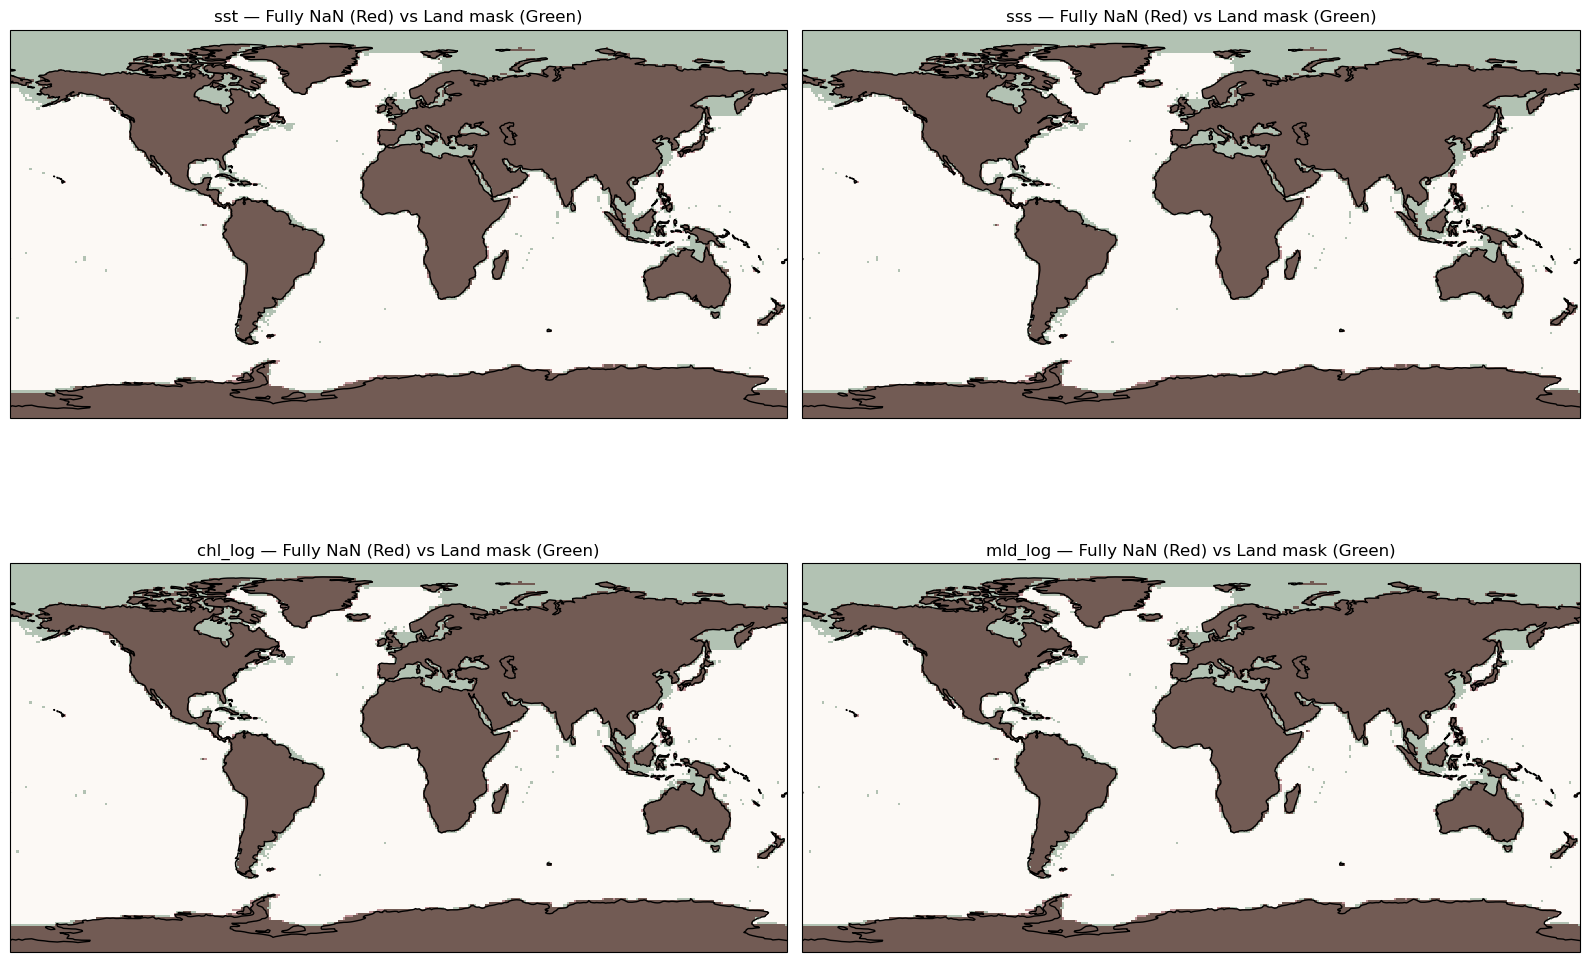

In [22]:
## Check the empty slice warning (for the first member of the first ESM)

import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# --- Parameters ---
first_ens = 'CESM2'
first_mem = 'member_r10i1p1f1'
init_date = '198202'
fin_date = '202312'
month = 0  # januari

member_short = first_mem.split('member_')[1]
pkl_file = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs/{first_ens}/{first_mem}/MLinput_{first_ens}_{member_short}_mon_1x1_{init_date}_{fin_date}.pkl"

# --- Load pickle file ---
with fs.open(pkl_file, 'rb') as f:
    df = pickle.load(f)

# --- Dimensions ---
lat_len = 180
lon_len = 360
n_time = df.shape[0] // (lat_len * lon_len)
print(f"n_time={n_time}, lat_len={lat_len}, lon_len={lon_len}")

# --- Correct reshaping of features (time, lat, lon) ---
features = ['sst','sss','chl_log','mld_log']
feature_dict = {}
for feature in features:
    arr = df[feature].values.reshape(n_time, lon_len, lat_len).transpose(0,2,1)  # transpose fixes lat/lon
    feature_dict[feature] = arr
    print(f"{feature}: reshaped to {arr.shape}, min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}")

# --- net_mask reshaped the same way ---
net_mask = df['net_mask'].values.reshape(n_time, lon_len, lat_len).transpose(0,2,1)

# --- Lat/lon arrays ---
lats = np.linspace(-89.5, 89.5, lat_len, dtype=np.float32)
lons = np.linspace(-179.5, 179.5, lon_len, dtype=np.float32)
print("Lat range:", lats[0], "→", lats[-1])
print("Lon range:", lons[0], "→", lons[-1])

# --- Plot ---
plt.figure(figsize=(16,12))

for i, feature in enumerate(features):
    arr = feature_dict[feature]

    # Fully NaN points for this month
    all_nan_mask = np.all(np.isnan(arr[month::12, :, :]), axis=0)

    # Corresponding net_mask for this month
    net_mask_month = net_mask[month::12, :, :]
    ocean_mask = np.all(~np.isnan(net_mask_month), axis=0)

    ax = plt.subplot(2, 2, i+1, projection=ccrs.PlateCarree())

    ax.coastlines()
    ax.set_global()

    # Red = fully NaN points
    ax.pcolormesh(lons, lats, all_nan_mask.astype(float),
                  transform=ccrs.PlateCarree(), cmap='Reds', alpha=0.6, shading='auto')

    # Green = land according to net_mask
    ax.pcolormesh(lons, lats, (~ocean_mask).astype(float),
                  transform=ccrs.PlateCarree(), cmap='Greens', alpha=0.3, shading='auto')

    plt.title(f"{feature} — Fully NaN (Red) vs Land mask (Green)")

plt.tight_layout()
plt.show()


In [16]:
### Check structure all_som_dicts
all_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict.pkl'
with fs.open(all_dict_path, 'rb') as f:
    all_som_dicts = pickle.load(f)
for ens, members_dict in all_som_dicts.items():
    print(f"Ensemble: {ens}")
    print(f"  Members: {list(members_dict.keys())}")

Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
  File "/tmp/ipykernel_4306/3535319328.py", line 4, in <module>
    all_som_dicts = pickle.load(f)
                    ^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/fsspec/spec.py", line 2129, in readinto
    data = self.read(out.nbytes)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/fsspec/spec.py", line 2118, in read
    self.cache._log_stats(),
    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/fsspec/caching.py", line 86, in _log_stats
    def _log_stats(self) -> str:
    
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-pack

KeyboardInterrupt: 

In [17]:
import fsspec

fs = fsspec.filesystem('gs')
file_path = 'gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/all_som_dicts.pkl'

# Haal file info op
info = fs.info(file_path)

# 'mtime' is al datetime object
last_modified_dt = info['mtime']
print(f"Last modified: {last_modified_dt}")

Last modified: 2025-09-22 21:22:07.775000+00:00


<span style="color:lightblue; font-size:30px; font-weight:bold;">Visualize the Provinces</span>

<span style="color:purple; font-size:20px; font-weight:bold;">Visualize the Variability in Provinces - Per Ensemble Member</span>

There are NaN values in the provinces array


/tmp/ipykernel_746/2070155484.py:565: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, provinces_variability_vmax)


Saved figure to ./Figures/SOM/Count_Provinces/Each_Member/count_unique_provinces_CESM2_member_r4i1p1f1.png


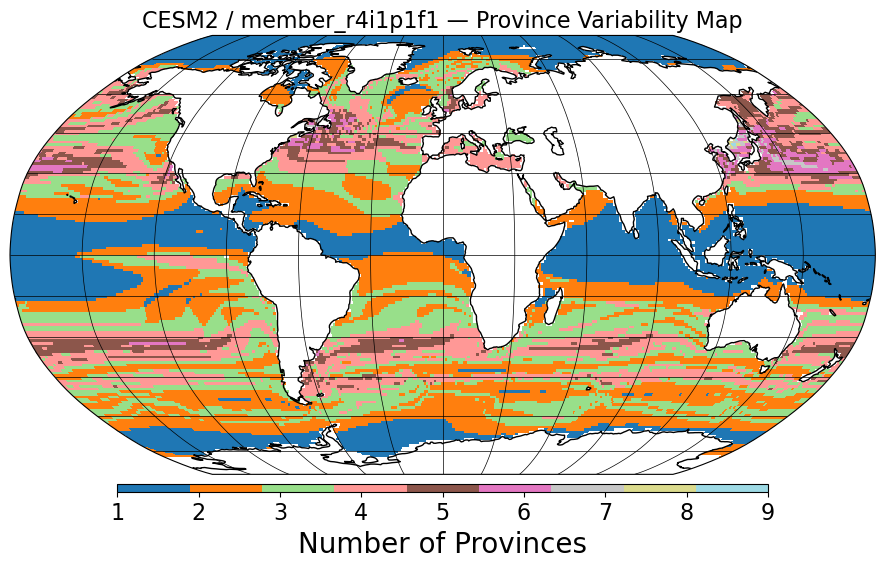

In [27]:
### Visualise the unique count of Provinces for each ensemble member
import fsspec
import pickle

fs = fsspec.filesystem('gs')
ens = "CESM2"
mem = "member_r4i1p1f1"

# Load only the ESM's SOM dict
esm_som_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict_{ens}.pkl'
with fs.open(esm_som_dict_path, "rb") as f:
    som_dict = pickle.load(f)

# Pick the member
som = som_dict[mem]

# Plot the member's province variability
som.PlotProvinceVariability(ens=ens, member=mem)

<span style="color:purple; font-size:20px; font-weight:bold;">Visualize the Variability in Provinces - All members of ESM</span>


Plotting ensemble: ACCESS-ESM1-5
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array


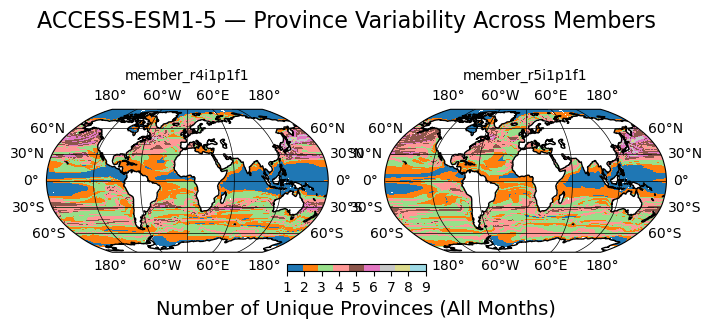

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_ACCESS-ESM1-5_all_members.png

Plotting ensemble: CESM2
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


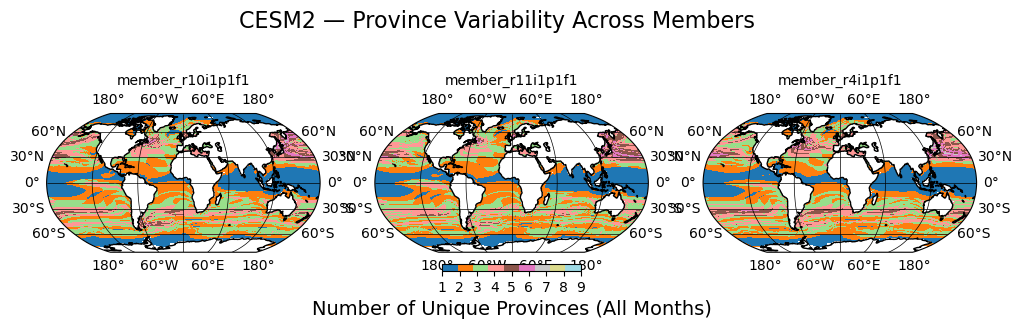

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_CESM2_all_members.png

Plotting ensemble: CESM2-WACCM
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


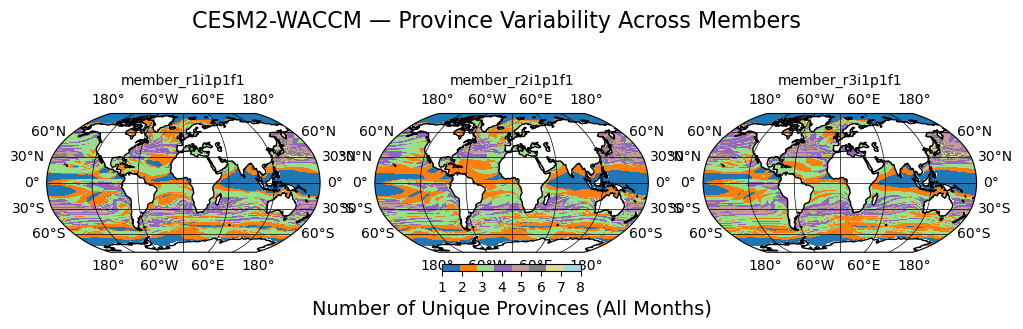

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_CESM2-WACCM_all_members.png

Plotting ensemble: CMCC-ESM2
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array


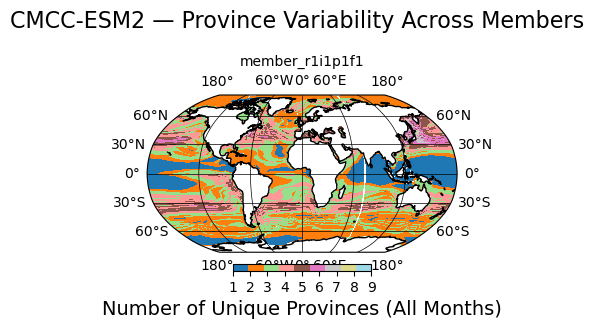

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_CMCC-ESM2_all_members.png

Plotting ensemble: CanESM5
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


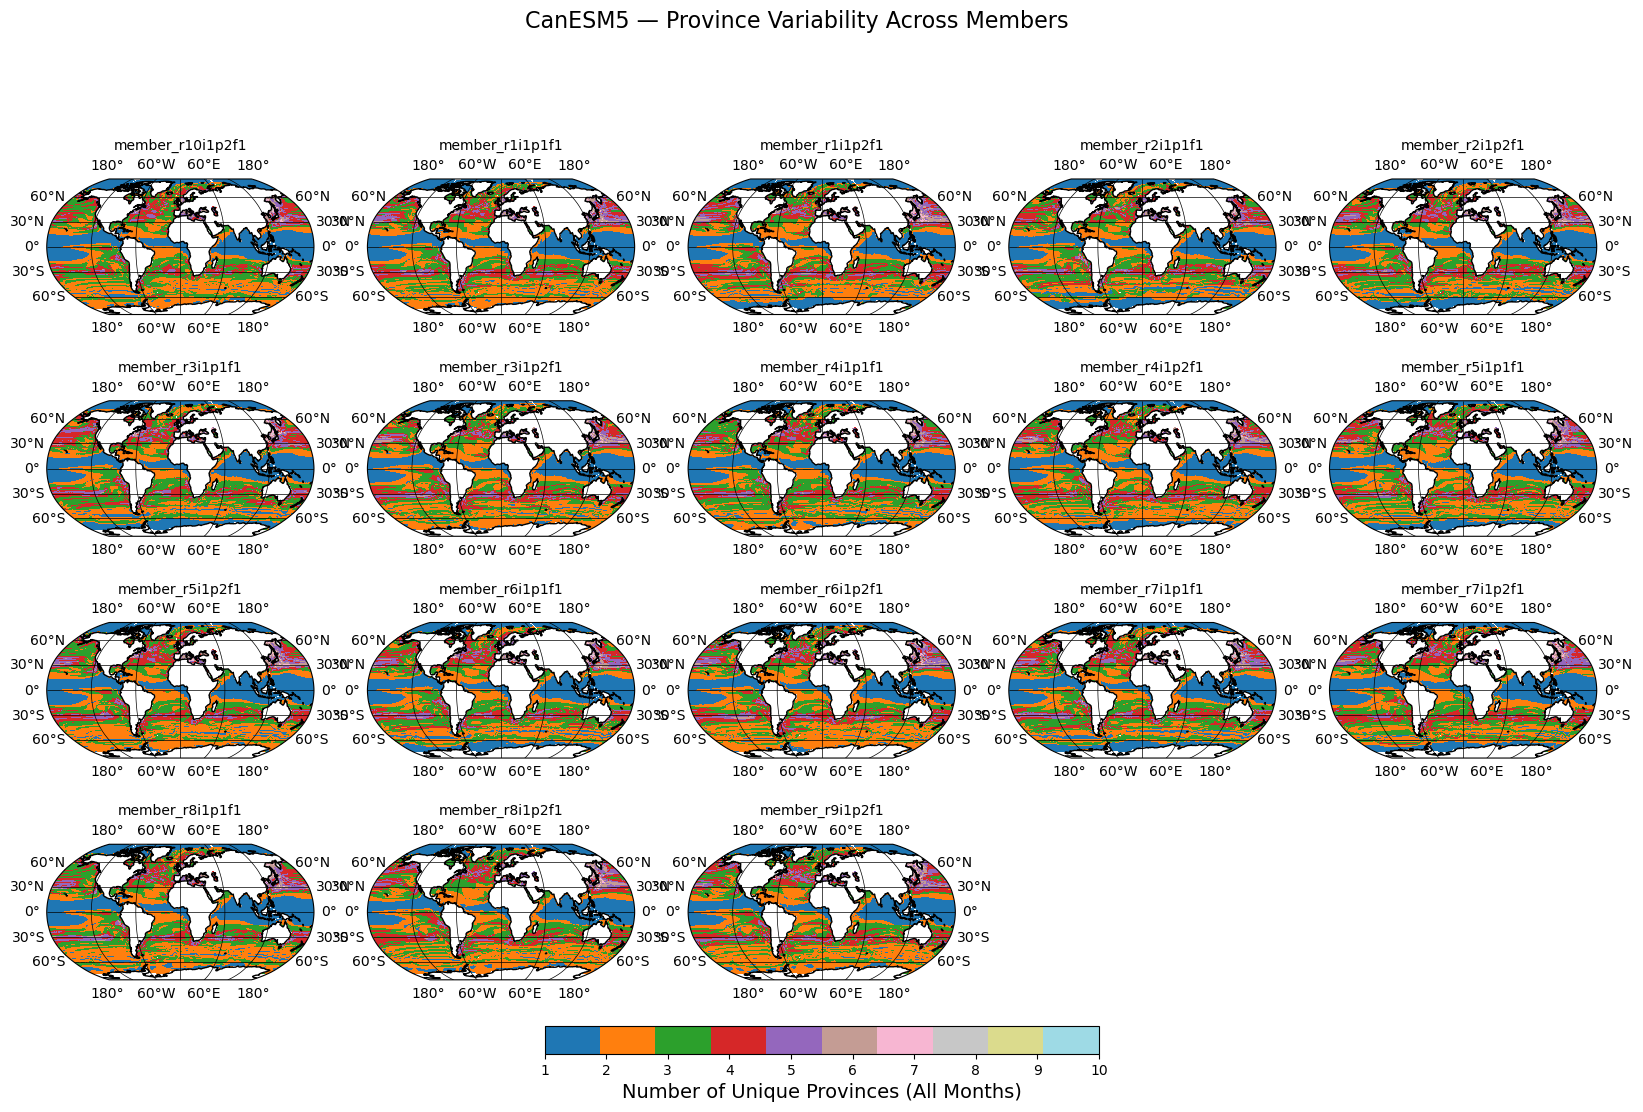

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_CanESM5_all_members.png

Plotting ensemble: CanESM5-CanOE
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


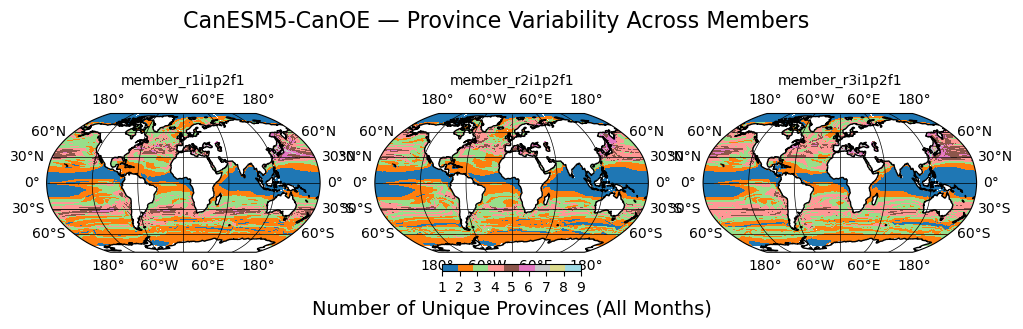

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_CanESM5-CanOE_all_members.png

Plotting ensemble: GFDL-ESM4
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array


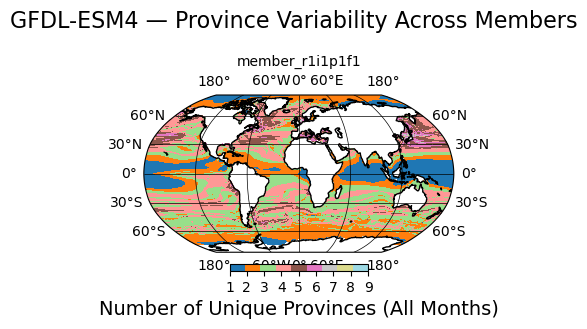

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_GFDL-ESM4_all_members.png

Plotting ensemble: MPI-ESM1-2-LR
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


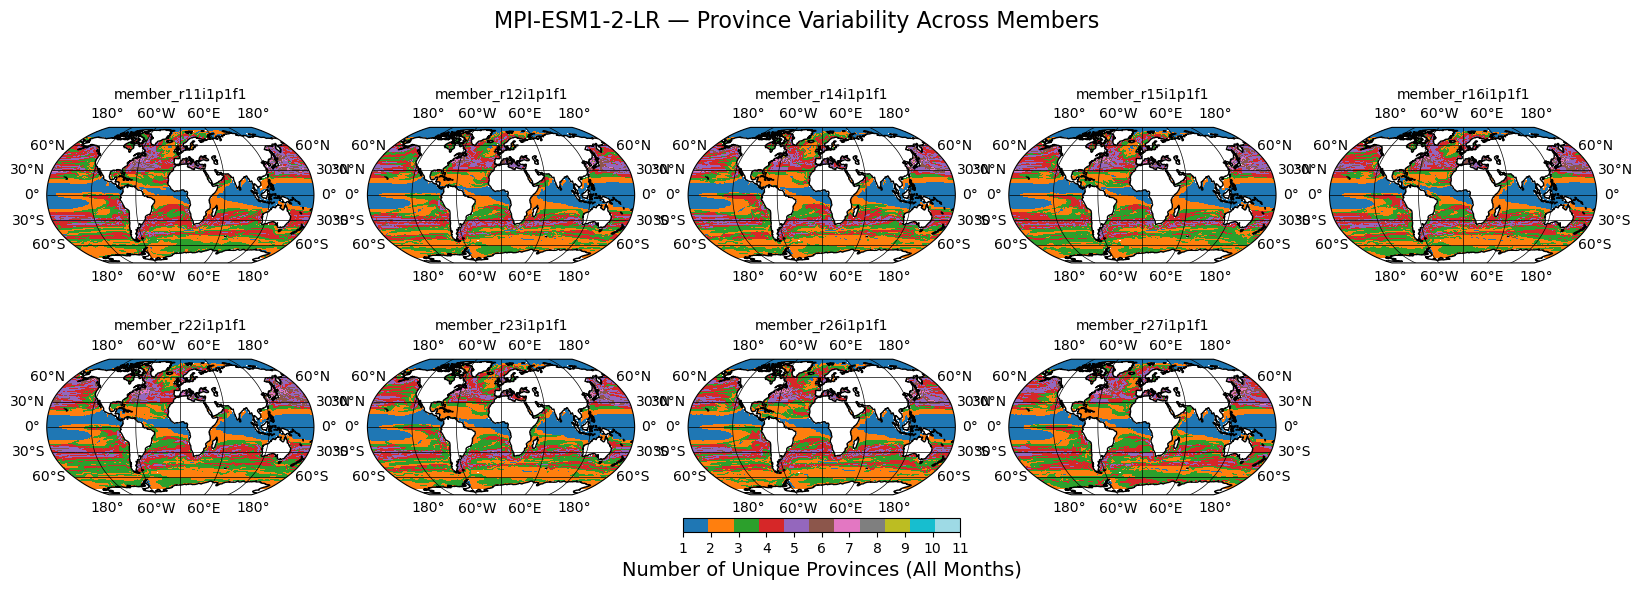

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_MPI-ESM1-2-LR_all_members.png

Plotting ensemble: UKESM1-0-LL
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


/tmp/ipykernel_457/1986093545.py:649: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20', max_var)


There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array
There are NaN values in the provinces array


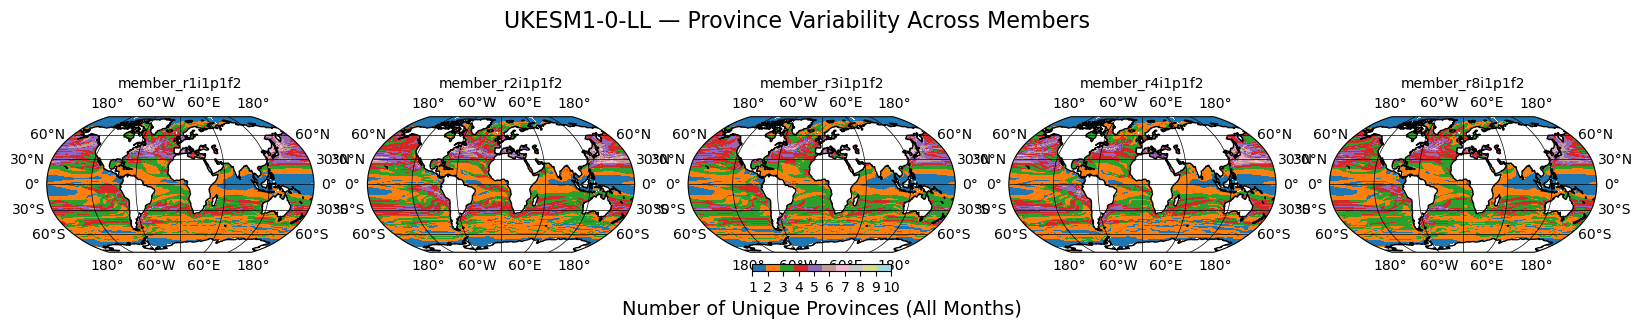

Saved figure to ./Figures/SOM/Count_Provinces/Ensemble/variability_UKESM1-0-LL_all_members.png


In [33]:
### Visualise all members of all ESMs - Unique Provinces

import fsspec
import pickle

fs = fsspec.filesystem('gs')

# List all ESMs you have processed
esm_list = ["ACCESS-ESM1-5", "CESM2","CESM2-WACCM", "CMCC-ESM2", "CanESM5", "CanESM5-CanOE","GFDL-ESM4", "MPI-ESM1-2-LR","UKESM1-0-LL"]  # or generate dynamically from GCS

for ens in esm_list:
    print(f"\nPlotting ensemble: {ens}")
    
    # Load only this ensemble's SOM dict
    esm_som_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict_{ens}.pkl'
    if not fs.exists(esm_som_dict_path):
        print(f"  {ens} not found, skipping.")
        continue
    
    with fs.open(esm_som_dict_path, "rb") as f:
        som_dict = pickle.load(f)
    
    # Initialize SOM object (for plotting)
    som_obj = SelfOrganizingMap()
    
    # Plot variability for all members in this ESM
    som_obj.PlotProvinceVariabilityEnsemble(som_dict, ens)

<span style="color:purple; font-size:20px; font-weight:bold;">Visualize the Main Province - Per Ensemble Member</span>

/tmp/ipykernel_746/2070155484.py:348: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_provinces)


Saved figure to ./Figures/SOM/Modal_Provinces/Each_Member/modal_province_MPI-ESM1-2-LR_member_r11i1p1f1.png


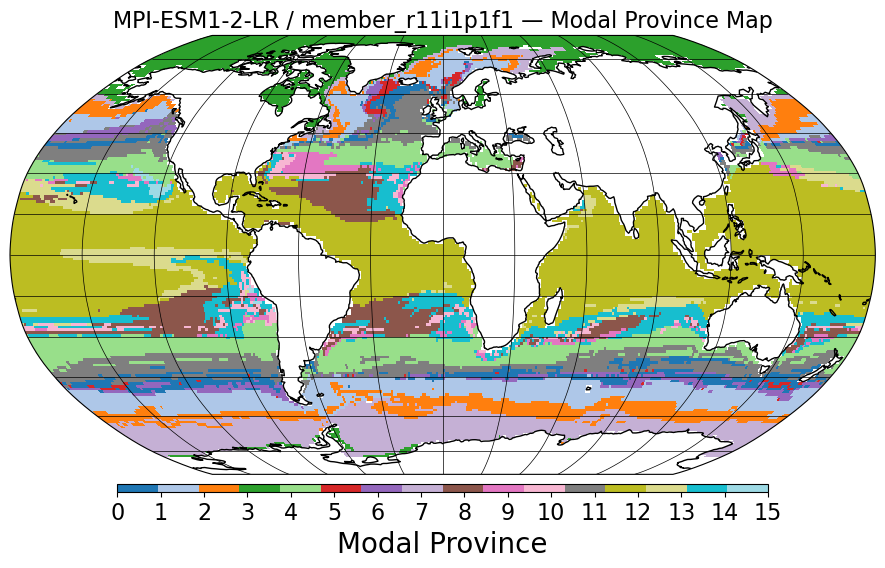

In [29]:
### Visualise the Dominant Provinces for each ensemble member
import fsspec
import pickle

fs = fsspec.filesystem('gs')
ens = "MPI-ESM1-2-LR"
mem = "member_r11i1p1f1"

# Load only the ESM's SOM dict
esm_som_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict_{ens}.pkl'
with fs.open(esm_som_dict_path, "rb") as f:
    som_dict = pickle.load(f)

# Pick the member
som = som_dict[mem]

# plot the dominant provinces
som.PlotModalProvince(ens=ens, member=mem)

<span style="color:purple; font-size:20px; font-weight:bold;">Visualize the Main Province - All members of ESM</span>


Plotting ensemble: ACCESS-ESM1-5


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_ACCESS-ESM1-5_all_members.png


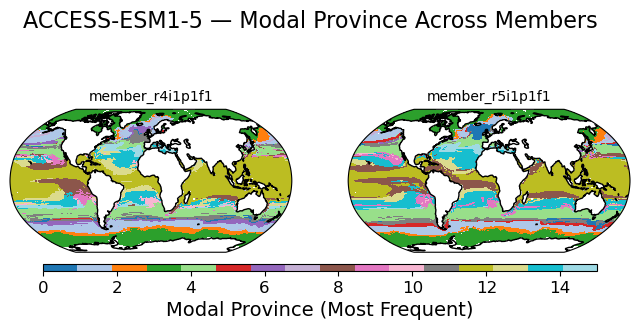


Plotting ensemble: CESM2


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_CESM2_all_members.png


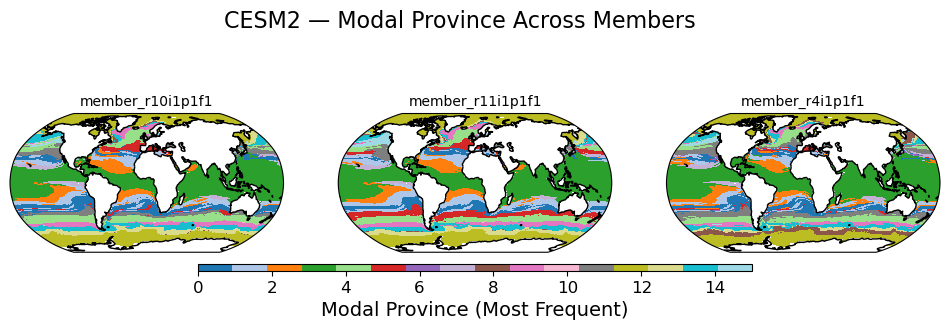


Plotting ensemble: CESM2-WACCM


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_CESM2-WACCM_all_members.png


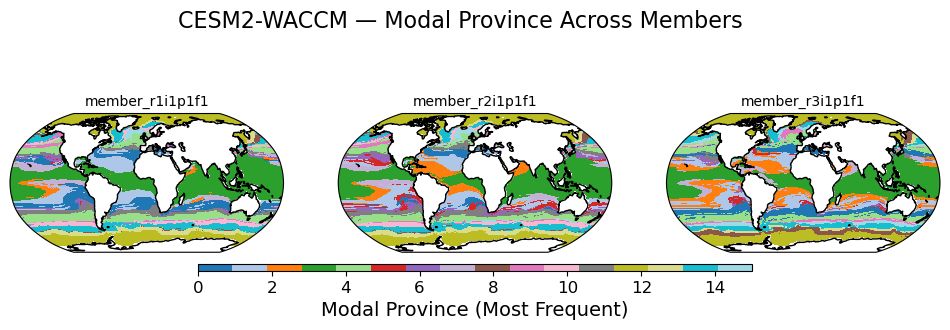


Plotting ensemble: CMCC-ESM2


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_CMCC-ESM2_all_members.png


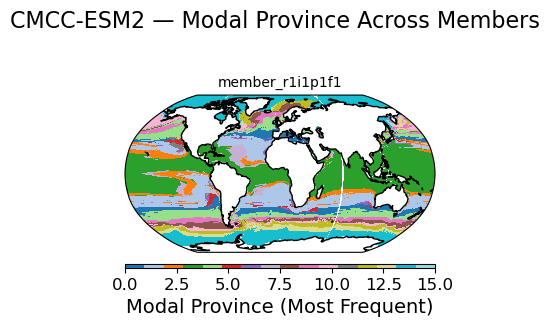


Plotting ensemble: CanESM5


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning:

Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_CanESM5_all_members.png


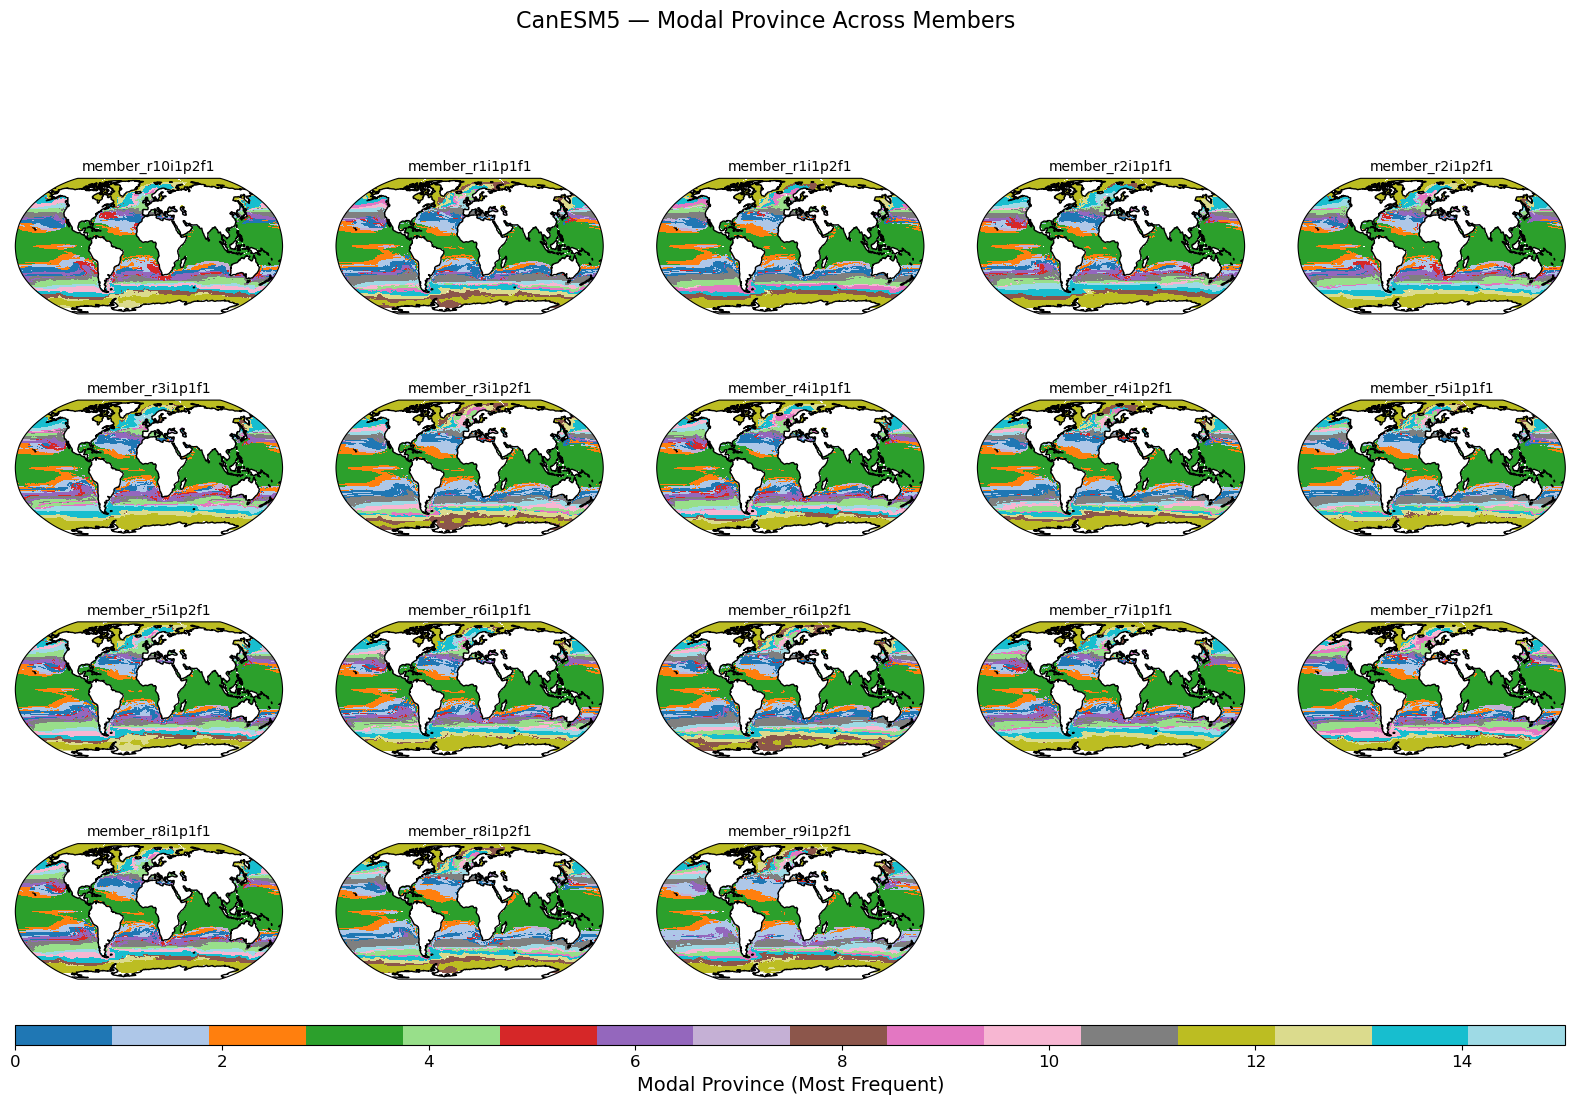


Plotting ensemble: CanESM5-CanOE


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_CanESM5-CanOE_all_members.png


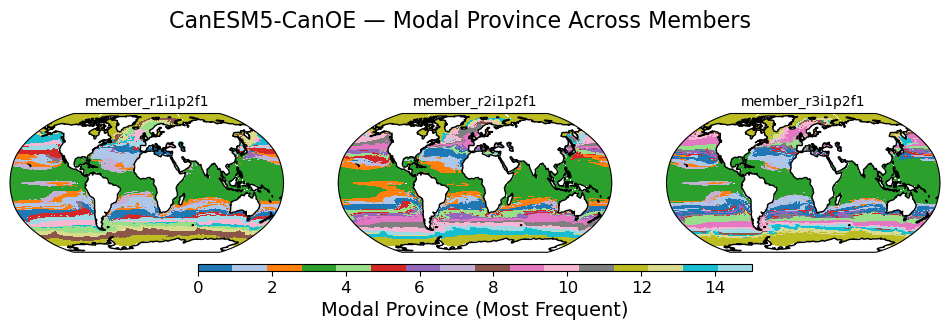


Plotting ensemble: GFDL-ESM4


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)


Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_GFDL-ESM4_all_members.png


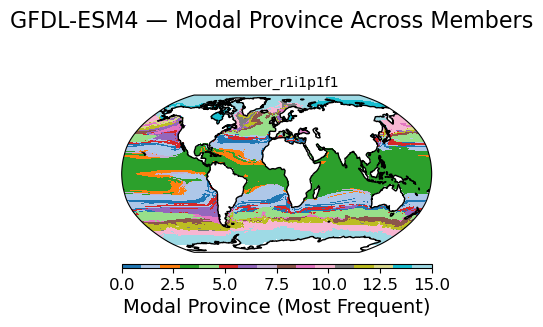


Plotting ensemble: MPI-ESM1-2-LR


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning:

Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_MPI-ESM1-2-LR_all_members.png


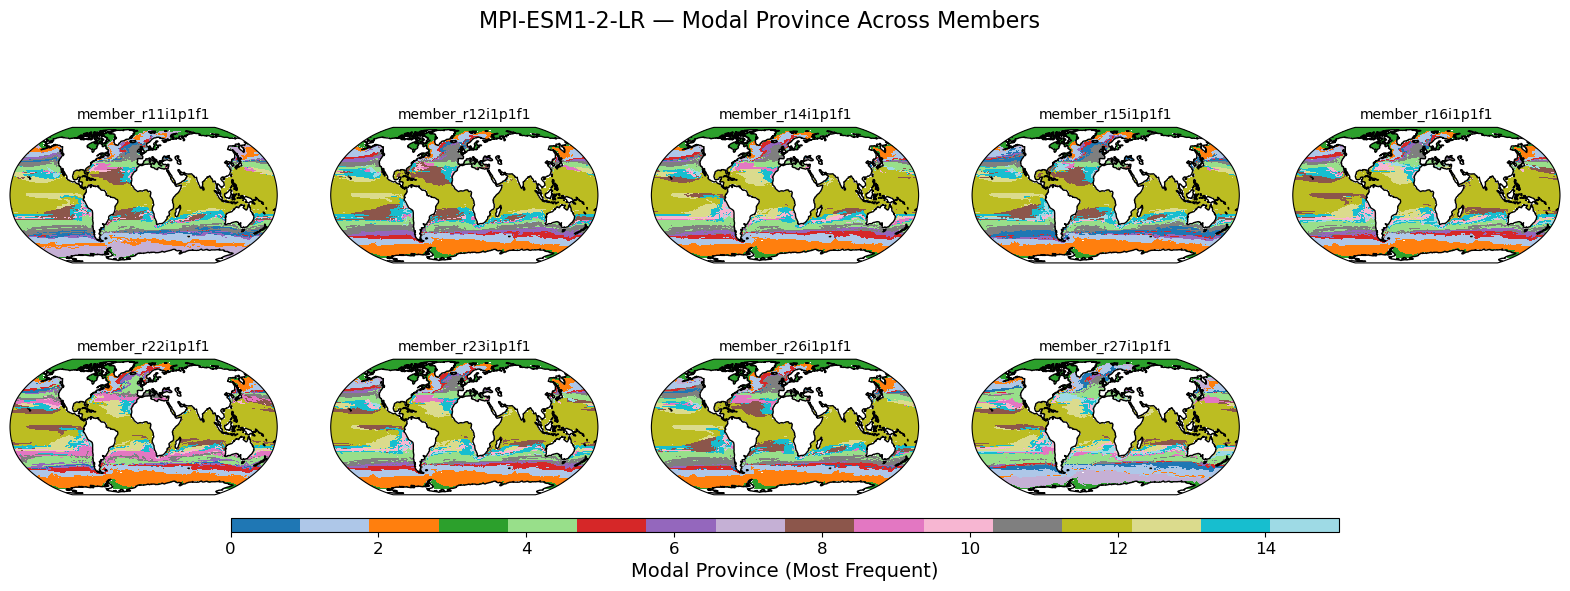


Plotting ensemble: UKESM1-0-LL


/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap(cmap, n_neurons)
/tmp/ipykernel_457/2070155484.py:469: MatplotlibDeprecationWarning:

Saved figure to ./Figures/SOM/Modal_Provinces/Ensemble/modal_province_UKESM1-0-LL_all_members.png


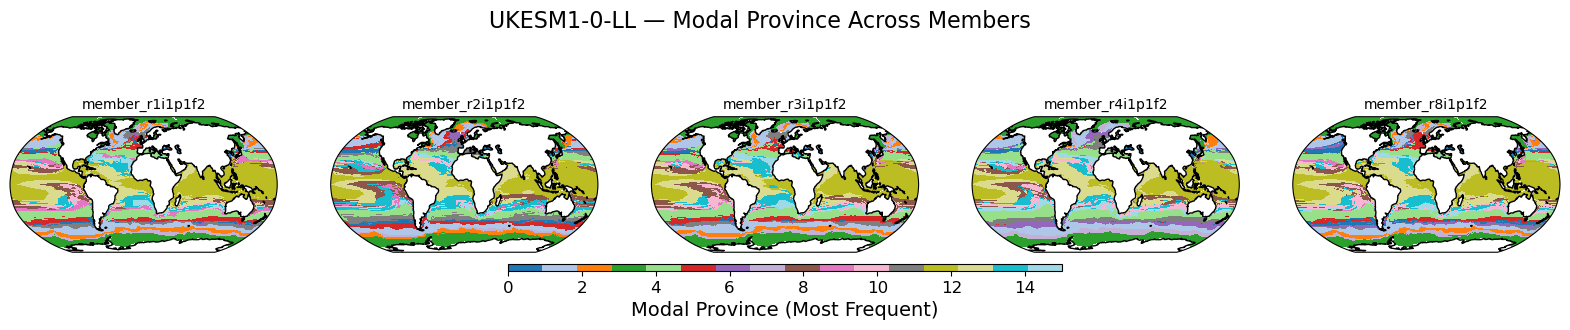

In [36]:
### Visualise all members of all ESMs - Dominant Provinces

import fsspec
import pickle
fs = fsspec.filesystem('gs')
# List all ESMs you have processed
esm_list = ["ACCESS-ESM1-5", "CESM2","CESM2-WACCM", "CMCC-ESM2", "CanESM5", "CanESM5-CanOE","GFDL-ESM4", "MPI-ESM1-2-LR","UKESM1-0-LL"]  # or generate dynamically from GCS

for ens in esm_list:
    print(f"\nPlotting ensemble: {ens}")
    
    # Load only this ensemble's SOM dict
    esm_som_dict_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/som_dict_{ens}.pkl'
    if not fs.exists(esm_som_dict_path):
        print(f"  {ens} not found, skipping.")
        continue
    
    with fs.open(esm_som_dict_path, "rb") as f:
        som_dict = pickle.load(f)
    
    # Initialize SOM object (for plotting)
    som_obj = SelfOrganizingMap()
    
    # Plot variability for all members in this ESM
    som_obj.PlotModalProvinceEnsemble(som_dict, ens)

<span style="color:purple; font-size:20px; font-weight:bold;">Visualize the Main Province - one member of each ESM</span>

<span style="color:hotpink; font-size:40px; font-weight:bold;">Feedforward Neural Network</span>

<span style="color:lightblue; font-size:30px; font-weight:bold;">Grid Search Approach </span>

In [57]:
# for grid search, we can specify the metric to optimize for
# the options we can currently choose between are 'nmse' (negative mean square error) and 'bias' 

### DEFINE APPROACH HERE: ###
grid_search_approach = 'nmse'

<span style="color:lightblue; font-size:30px; font-weight:bold;">Paths for FFN </span>

In [58]:
# paths for the FFN part
output_dir_FFN_fig = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/Figures/Performance/'
output_dir_FFN_recon = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/Reconstructions/'
output_dir_FFN_metrics = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/Performance_metrics/'
output_dir_FFN = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/'

#model_output_dir = f"{output_dir_FFN}/trained" # where to save ML models
#recon_output_dir = f"{output_dir_FFN}/reconstructions" # where to save ML reconstructions

<span style="color:lightblue; font-size:30px; font-weight:bold;">Get Data Ready</span>

<span style="color:purple; font-size:20px; font-weight:bold;">Custom Class</span>

In [9]:
####  DEFINE CLASS
class FeedForwardNetwork_Get_Data_Ready:
    """
        NAME        : Feedforward neural network
    """
    def LoadInputDataMember(self, pkl_file, features_select=None):
        """
        Load MLinput data for a single member and convert to 3D arrays (time x lat x lon).
        """
        if not fs.exists(pkl_file):
            print(f"File not found: {pkl_file}")
            return

        print(f"Loading MLinput file: {pkl_file}")
        with fs.open(pkl_file, 'rb') as f:
            df = pickle.load(f)

        if features_select is not None: 
            df = df[features_select]

        lat_len = 180
        lon_len = 360
        n_time = df.shape[0] // (lat_len * lon_len)
        self.n_time = n_time
        self.lat_values = np.linspace(-89.5, 89.5, lat_len, dtype=np.float32)
        self.lon_values = np.linspace(-179.5, 179.5, lon_len, dtype=np.float32)

        # Create dictionary of 3D arrays 
        self.input_array_dict = {} 
        for feature in df.columns: 
            arr = df[feature].values.reshape(n_time, lat_len, lon_len) # reshape the input data into time x lat x lon dimensions 
            self.input_array_dict[feature] = arr
        
        # Add lat/lon arrays 
        self.input_array_dict['lat'] = np.tile(np.linspace(-89.5, 89.5, lat_len, dtype=np.float32), (lon_len, 1)).T 
        self.input_array_dict['lon'] = np.tile(np.linspace(-179.5, 179.5, lon_len, dtype=np.float32), (lat_len, 1))

        print("Input arrays loaded with shape per feature:") 
        for k, v in self.input_array_dict.items(): 
            print(f" {k}: {v.shape}") 
        print("Feature names used:") 
        print(list(self.input_array_dict.keys()))
            
    def CropInputData(self,
                      date_start='1982-02-01',
                      date_end='2023-12-31',
                      latitude_min=-90., latitude_max=90.,
                      longitude_min=-180., longitude_max=180.):

        """
        Crop input arrays in time and geography.

        Parameters
        ----------
        date_start : str
            Start of time range (ISO format: YYYY-MM-DD)
        date_end : str
            End of time range (ISO format: YYYY-MM-DD)
        latitude_min, latitude_max : float
            Latitude bounds for cropping
        longitude_min, longitude_max : float
            Longitude bounds for cropping
        """

        # --- Check if input data exists ---
        if len(self.input_array_dict) == 0:
            raise ValueError('Input data not found. Run LoadInputDataMember first.')

        # --- Crop time ---
        dates = pd.date_range(start=date_start, end=date_end, freq='MS')
        n_time = self.input_array_dict[list(self.input_array_dict.keys())[0]].shape[0]

        if n_time != len(dates):
            print(f"WARNING: input array time length ({n_time}) != date range length ({len(dates)})")

        # Only keep the overlapping time range
        crop_len = min(n_time, len(dates))
        for feature in self.input_array_dict.keys():
            self.input_array_dict[feature] = self.input_array_dict[feature][:crop_len, :, :]
    
        # --- Crop geography ---
        lat_idx = np.where((self.lat_values >= latitude_min) & (self.lat_values <= latitude_max))[0]
        lon_idx = np.where((self.lon_values >= longitude_min) & (self.lon_values <= longitude_max))[0]
    
        for feature in self.input_array_dict.keys():
            arr = self.input_array_dict[feature]
            if arr.ndim == 3:  # time x lat x lon
                self.input_array_dict[feature] = arr[:, lat_idx, :][:, :, lon_idx]
            elif arr.ndim == 2:  # lat x lon
                self.input_array_dict[feature] = arr[lat_idx, :][:, lon_idx]

        # Update lat/lon arrays to cropped
        self.lat_values = self.lat_values[lat_idx]
        self.lon_values = self.lon_values[lon_idx]

        print(f"Cropped input data to time ({crop_len} months), "
              f"lat ({len(lat_idx)} points), lon ({len(lon_idx)} points)")
    
    def FlattenInputData(input_array_dict, features_sel_FFN=None, target_sel=['spco2'], provinces=None, year_start=1982):
        """
        Flatten 3D input arrays (time x lat x lon) into long-format DataFrames for ML,
        including features, metadata, target, and dominant province.

        Parameters
        ----------
        input_array_dict : dict
            Dictionary with 3D arrays (time x lat x lon) for each feature.
            Must include 'lat', 'lon', and 'net_mask'.
        features_sel_FFN : list, optional
            List of feature names to include. Defaults to all keys in input_array_dict except 'lat', 'lon', 'net_mask'.
        target_sel : list, optional
            List with name(s) of target variables. Defaults to ['spco2'].
        provinces : np.ndarray, optional
            2D array (lat x lon) of dominant provinces.
        year_start : int
            Year of first time step.

        Returns
        -------
        df_features, df_meta, df_target, df_province : pd.DataFrame
        """
        import numpy as np
        import pandas as pd

        # --- Select features ---
        if features_sel_FFN is None:
            features_sel_FFN = [k for k in input_array_dict.keys() if k not in ['lat', 'lon', 'net_mask', 'socat_mask']]
        print(f"[INFO] Selected features: {features_sel_FFN}")

         # --- Get dimensions ---
        time_len, lat_len, lon_len = input_array_dict[features_sel_FFN[0]].shape
        print(f"[INFO] Shape of features (time x lat x lon): {time_len} x {lat_len} x {lon_len}")

        # --- Flatten features ---
        feature_list = []
        for key in features_sel_FFN:
            arr = input_array_dict[key]
            feature_list.append(arr.ravel())
            print(f"[DEBUG] Feature '{key}' flattened, shape: {arr.ravel().shape}")
        df_features = pd.DataFrame(np.column_stack(feature_list), columns=features_sel_FFN)
        print(f"[INFO] df_features shape: {df_features.shape}")

        # --- Flatten metadata ---
        lat_grid = np.tile(input_array_dict['lat'], time_len)  # repeats lat for each time step
        lon_grid = np.tile(input_array_dict['lon'], time_len)  # repeats lon for each time step
        # Month/year arrays
        months = np.arange(1, 13)
        n_years = int(np.ceil(time_len / 12))
        years = np.repeat(np.arange(year_start, year_start + n_years), 12)[:time_len]
        month_grid = np.tile(months, n_years)[:time_len]
        month_flat = np.repeat(month_grid, lat_len * lon_len)
        year_flat = np.repeat(years, lat_len * lon_len)
        # net_mask
        net_mask_flat = input_array_dict['net_mask'].ravel()
        socat_mask_flat = input_array_dict['socat_mask'].ravel()  
        df_meta = pd.DataFrame({
            'lat': lat_grid.ravel(),
            'lon': lon_grid.ravel(),
            'month': month_flat,
            'year': year_flat,
            'net_mask': net_mask_flat, 
            'socat_mask': socat_mask_flat})
        print(f"[INFO] df_meta shape: {df_meta.shape}")

        # --- Flatten target ---
        target_list = []
        for tgt in target_sel:
            if tgt in input_array_dict:
                target_list.append(input_array_dict[tgt].ravel())
                print(f"[DEBUG] Target '{tgt}' flattened, shape: {input_array_dict[tgt].ravel().shape}")
            else:
                target_list.append(np.full(time_len*lat_len*lon_len, np.nan))
                print(f"[WARN] Target '{tgt}' not found. Filling with NaN.")
        df_target = pd.DataFrame(np.column_stack(target_list), columns=target_sel)
        print(f"[INFO] df_target shape: {df_target.shape}")

        # --- Flatten dominant province ---
        if provinces is not None:
            province_full = np.tile(provinces, (time_len, 1, 1))
            df_province = pd.DataFrame({'province': province_full.ravel()})
            print(f"[INFO] df_province shape: {df_province.shape}")
        else:
            df_province = pd.DataFrame()
            print("[WARN] provinces array not provided.")

        # --- Done ---
        print("[INFO] Flattening complete.")
        return df_features, df_meta, df_target, df_province


<span style="color:purple; font-size:20px; font-weight:bold;">Perform Class For All Members</span>

In [10]:
### Run the above functions to get the data ready for each ensemble member
import fsspec
import os
import pickle
import numpy as np
import xarray as xr

output_dir_base = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN'
final_output_file = f"{output_dir_base}/FFN_data_ready.pkl"

overwrite = False  # Set to True to regenerate the file even if it exists

# --- List ensembles in GCS ---
esm_paths = fs.ls(MLinputs_path_abby, detail=False)
esm_list = [p.split('/')[-1] for p in esm_paths]

for esm in esm_list:
    esm_output_file = f"{output_dir_base}/FFN_data_ready_{esm}.pkl"

    # Skip if already exists and not overwriting
    if fs.exists(esm_output_file) and not overwrite:
        print(f"[INFO] ESM file already exists: {esm_output_file}. Skipping.")
        continue
        
    all_data_esm = {}
    print(f"[INFO] Processing ESM: {esm}")
    esm_gcs_path = f"{MLinputs_path_abby}/{esm}"
    
    # List members
    member_paths = fs.ls(esm_gcs_path, detail=False)
    member_list = [p.split('/')[-1] for p in member_paths]
    print(f"[INFO] Found members: {member_list}")

    for member in member_list:
        print(f"[INFO]   Processing Member: {member}")

        # ML input pickle file
        member_short = member.split('member_')[1]
        pkl_file = f"{esm_gcs_path}/{member}/MLinput_{esm}_{member_short}_mon_1x1_198202_202312.pkl"
        print(f"[DEBUG]   Loading MLinput pickle from: {pkl_file}")

        # load the data
        ffn = FeedForwardNetwork_Get_Data_Ready()
        ffn.LoadInputDataMember(pkl_file, features_select=features_select)
        #ffn.CropInputData(date_start='1982-02-01', date_end='2023-12-31')
        print(f"[DEBUG]   Input arrays keys: {list(ffn.input_array_dict.keys())}")
        print(f"[DEBUG]   Shape of first feature: {list(ffn.input_array_dict.values())[0].shape}")
 
        # Load provinces Zarr
        zarr_path = f"gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/SOM/{esm}/{member}/som-output_provinces.zarr"
        print(f"[DEBUG]   Loading provinces from: {zarr_path}")
        provinces_da = xr.open_zarr(zarr_path, consolidated=True)['provinces']
        provinces_data = provinces_da.values
        print(f"[DEBUG]   Provinces shape: {provinces_data.shape}")
        lat_len, lon_len = provinces_data.shape[1], provinces_data.shape[2]

        # Compute dominant province per grid cell
        provinces_mode = np.full((lat_len, lon_len), np.nan)
        for i in range(lat_len):
            for j in range(lon_len):
                cell_values = provinces_data[:, i, j]
                vals_nonan = cell_values[~np.isnan(cell_values)]
                if vals_nonan.size == 0:
                    continue
                uniq, counts = np.unique(vals_nonan, return_counts=True)
                provinces_mode[i, j] = uniq[np.argmax(counts)]
        print(f"[DEBUG]   Computed dominant provinces array shape: {provinces_mode.shape}")

        # Flatten input data
        df_features, df_meta, df_target, df_province = FeedForwardNetwork_Get_Data_Ready.FlattenInputData(
            ffn.input_array_dict,
            features_sel_FFN=features_sel_FFN,
            target_sel=target_sel,
            provinces=provinces_mode,
            year_start=1982)
        print(f"[INFO]   Flattened data shapes -> Features: {df_features.shape}, Metadata: {df_meta.shape}, Target: {df_target.shape}, Province: {df_province.shape}")

        # Store in dictionary
        all_data_esm[member] = {
            'features': df_features,
            'metadata': df_meta,
            'target': df_target,
            'province': df_province}
        print(f"[INFO]   Stored flattened data for {member}")

    # --- Save per ESM ---
    with fs.open(esm_output_file, 'wb') as f:
        pickle.dump(all_data_esm, f)
    print(f"[INFO] Saved ESM {esm} to {esm_output_file}")

[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_ACCESS-ESM1-5.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_CESM2.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_CESM2-WACCM.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_CMCC-ESM2.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_CanESM5.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_data_ready_CanESM5-CanOE.pkl. Skipping.
[INFO] ESM file already exists: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMF

KeyboardInterrupt: 

<span style="color:purple; font-size:20px; font-weight:bold;">Make the Train/Validation/Test dataset - for all members </span>

In [ ]:
# -------------------------------
# --- Imports
# -------------------------------
import fsspec
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

# -------------------------------
# --- Helper function: Province-based splits with masks
# -------------------------------
def create_province_splits_with_masks(esm_data, test_frac=0.15, val_frac=0.15, random_state=42):
    """
    For each member in the given ESM:
        - Split SOCAT points (net_mask==1 & socat_mask==1) into train/val/test
        - Keep non-SOCAT points (net_mask==1 & socat_mask==0) as separate test ("socat_out")
    Returns esm_data with 'splits' added for each member.
    Indices of the original DataFrame are preserved, so assignment back using .loc works.
    """
    for member, data_dict in esm_data.items():
        print(f"[INFO] Processing & splitting data for member {member}")
        
        df_features = data_dict['features']
        df_meta     = data_dict['metadata']
        df_target   = data_dict['target']
        df_province = data_dict['province']
        # Add row_id column to track original row positions
        df_features['row_id'] = np.arange(len(df_features))

        # Keep only valid rows
        valid_mask = df_features.notna().all(axis=1) & df_target.notna().all(axis=1)
        # Masks for SOCAT and non-SOCAT, but only on valid rows
        mask_net_socat = valid_mask & (df_meta['net_mask'] == 1) & (df_meta['socat_mask'] == 1)
        mask_socat_out = valid_mask & (df_meta['net_mask'] == 1) & (df_meta['socat_mask'] == 0)

        # Filter SOCAT and non-SOCAT
        df_features_valid = df_features[mask_net_socat]
        df_meta_valid = df_meta[mask_net_socat]
        df_target_valid = df_target[mask_net_socat]
        df_province_valid = df_province[mask_net_socat]

        df_features_socat_out = df_features[mask_socat_out]
        df_meta_socat_out     = df_meta[mask_socat_out]
        df_target_socat_out   = df_target[mask_socat_out]
        df_province_socat_out = df_province[mask_socat_out]

        # Split per province
        provinces_unique = df_province_valid.squeeze().unique()  # squeeze converts single-column DF → Series
        split_dict = {}

        for prov in provinces_unique:
            mask = df_province_valid.squeeze() == prov
            n_rows = mask.sum()
            if n_rows == 0:
                print(f"[WARNING] No valid rows for province {prov}. Skipping.")
                continue
            
            # Original row indices in df_features
            features_sub = df_features_valid[mask]
            meta_sub     = df_meta_valid[mask]
            target_sub   = df_target_valid[mask]
            province_sub = df_province_valid[mask]

            # Train/val/test split using numpy positions
            all_indices = np.arange(len(features_sub))  # gebruik features_sub, niet prov_orig_indices
            idx_train_val, idx_test = train_test_split(all_indices, test_size=test_frac, random_state=random_state)
            idx_train, idx_val = train_test_split(idx_train_val, test_size=val_frac, random_state=random_state)

            # SOCAT-out points for this province
            mask_socat_prov = df_province_socat_out['province'] == prov
            features_socat = df_features_socat_out[mask_socat_prov]
            meta_socat     = df_meta_socat_out[mask_socat_prov]
            target_socat   = df_target_socat_out[mask_socat_prov]
            province_socat = df_province_socat_out[mask_socat_prov]

            # Store splits with original DataFrame indices
            split_dict[prov] = {
                    'train': {
                    'features': features_sub.iloc[idx_train_val],
                    'metadata': meta_sub.iloc[idx_train_val],
                    'target': target_sub.iloc[idx_train_val],
                    'province': province_sub.iloc[idx_train_val],
                    'orig_row_id': features_sub.iloc[idx_train_val]['row_id'].to_numpy()
                },
                    'val': {
                        'features': features_sub.iloc[idx_val],
                        'metadata': meta_sub.iloc[idx_val],
                        'target': target_sub.iloc[idx_val],
                        'province': province_sub.iloc[idx_val],
                        'orig_row_id': features_sub.iloc[idx_val]['row_id'].to_numpy()
                },
                    'test': {
                        'features': features_sub.iloc[idx_test],
                        'metadata': meta_sub.iloc[idx_test],
                        'target': target_sub.iloc[idx_test],
                        'province': province_sub.iloc[idx_test],
                        'orig_row_id': features_sub.iloc[idx_test]['row_id'].to_numpy()
                },
                    'socat_out': {
                        'features': features_socat,
                        'metadata': meta_socat,
                         'target': target_socat,
                        'province': province_socat,
                        'orig_row_id': features_socat['row_id'].to_numpy()
                }
            }

        esm_data[member]['splits'] = split_dict
        print(f"[INFO] Done splitting member {member}, provinces: {len(split_dict)}")

    return esm_data
    
# -------------------------------
# --- Configuration
# -------------------------------
overwrite = False
output_dir_base = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN'
fs = fsspec.filesystem('gs')

# -------------------------------
# --- Process each ESM separately
# -------------------------------
esm_paths = fs.ls(output_dir_base, detail=False)
esm_list = []
for p in esm_paths:
    fname = p.split('/')[-1]
    if fname.startswith('FFN_data_ready_') and fname.endswith('.pkl'):
        esm_name = fname.replace('FFN_data_ready_','').replace('.pkl','')
        esm_list.append(esm_name)
        
for esm in esm_list:
    esm_ready_file =  f"{output_dir_base}/FFN_data_ready_{esm}.pkl"
    output_file = f"{output_dir_base}/FFN_train_test_val_socat_{esm}.pkl"

    if fs.exists(output_file) and not overwrite:
        print(f"[INFO] Train/val/test splits already exist for {esm}: {output_file}. Skipping.")
        continue

    print(f"[INFO] Processing ESM: {esm}")

    # Load ESM ready data
    with fs.open(esm_ready_file, 'rb') as f:
        esm_data = pickle.load(f)
    
    # --- DEBUG: check keys and metadata columns ---
    import pprint
    pprint.pprint(esm_data.keys())  # list members
    for member, data_dict in esm_data.items():
        print(f"\nMember: {member}")
        print("Data keys:", data_dict.keys())
        print("Metadata columns:", data_dict['metadata'].columns)

    # Create splits per member/province
    esm_splits = create_province_splits_with_masks(esm_data, test_frac=0.15, val_frac=0.15, random_state=42)

    # Save split file for this ESM
    with fs.open(output_file, 'wb') as f:
        pickle.dump(esm_splits, f)

    print(f"[INFO] Train/val/test/socat splits saved for {esm} → {output_file}")


[INFO] Train/val/test splits already exist for ACCESS-ESM1-5: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_train_test_val_socat_ACCESS-ESM1-5.pkl. Skipping.
[INFO] Train/val/test splits already exist for CESM2-WACCM: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_train_test_val_socat_CESM2-WACCM.pkl. Skipping.
[INFO] Train/val/test splits already exist for CESM2: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_train_test_val_socat_CESM2.pkl. Skipping.
[INFO] Train/val/test splits already exist for CMCC-ESM2: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_train_test_val_socat_CMCC-ESM2.pkl. Skipping.
[INFO] Train/val/test splits already exist for CanESM5-CanOE: gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/FFN_train_test_val_socat_CanESM5-CanOE.pkl. Skipping.
[INFO] Processing ESM: CanESM5


<span style="color:lightblue; font-size:30px; font-weight:bold;">Do The Hyperparameter Tuning</span>

<span style="color:purple; font-size:20px; font-weight:bold;">For all members of each ESM - for all its provinces</span>

In [ ]:
### For every ESM: do the hps tuning for every member 

# We have to do the hps tuning for every member because the provinces ofcourse change within different ESM and its different members - just use 5 trials to start with and little epochs (because of the time it will take)
# don't do the CV for now, otherwise it will take even longer - just the training and validation set to define the best hps set per member

# -------------------------------
# --- Imports
# -------------------------------
import pickle
import os
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

# -------------------------------
# --- Hyperparameter Tuning Functions
# -------------------------------

# not using for now - using the RMSE
def bias_calc(y_true, y_pred):
    return np.abs(np.mean(y_pred) - np.mean(y_true))

def build_and_compile_model(hp, input_shape, normalizer):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_shape,)))
    model.add(normalizer)
    
    for i in range(hp.Int('num_layers', 1, 3)):  
        units = hp.Int(f'units_{i}', 10, 150, step=10)
        model.add(layers.Dense(units))
        activation_function = hp.Choice('activation', ['relu', 'elu'])
        model.add(layers.Activation(activation_function))
    
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3])
        ),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

def create_tf_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -------------------------------
# --- Main Hyperparameter Tuning Loop
# -------------------------------
overwrite = False
n_trials = 5
epochs = 10
batch_size = 128

fs = fsspec.filesystem('gs')
base_gcs_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/best_hps/'

# Loop over every ESM → member → province
for esm, members in all_data_existing.items():
    for member, data_dict in members.items():
        splits = data_dict['splits']
        for prov, split_data in splits.items():
            # GCS path for this province
            province_fname = f"best_hps_{esm}_{member}_{prov}.pkl"
            gcs_dir = f"{base_gcs_path}{esm}/{member}/"
            fs.makedirs(gcs_dir, exist_ok=True)
            gcs_file_path = os.path.join(gcs_dir, province_fname)

            if fs.exists(gcs_file_path) and not overwrite:
                print(f"[INFO] Hyperparameters already exist for {esm}/{member}/{prov}, skipping.")
                continue

            print(f"[INFO] Tuning {esm}/{member}, province {prov}")
            X_train = split_data['train']['features'].to_numpy()
            y_train = split_data['train']['target'].to_numpy().flatten()
            X_val   = split_data['val']['features'].to_numpy()
            y_val   = split_data['val']['target'].to_numpy().flatten()
            input_shape = X_train.shape[1]

            tuner = kt.BayesianOptimization(
                hypermodel=lambda hp: build_and_compile_model(hp, input_shape, keras.layers.Normalization()),
                objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                max_trials=n_trials,
                overwrite=overwrite,
                directory=None,
                project_name=f"{esm}_{member}_{prov}"
            )

            train_ds = create_tf_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
            val_ds   = create_tf_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)

            tuner.search(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)

            best_hp = tuner.get_best_hyperparameters(1)[0]
            best_hp_values = best_hp.values

            # Save per province on GCS
            with fs.open(gcs_file_path, 'wb') as f:
                pickle.dump(best_hp_values, f)
            print(f"[INFO] Saved best hyperparameters: {gcs_file_path}")


<span style="color:purple; font-size:20px; font-weight:bold;"> One hps tuning for each ESM </span>

In [11]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Directories
reconstructions_dir = './Reconstructions'
output_dir_local = './Figures'
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Performance_per_ESM")
os.makedirs(save_dir_local, exist_ok=True)

# ESM list
esm_list = ["ACCESS-ESM1-5"]#, "CanESM5", "CESM2-WACCM", "CESM2", "CMCC-ESM2",
           # "CanESM5-CanOE", "GFDL-ESM4", "MPI-ESM1-2-LR", "UKESM1-0-LL"]

# Loop over ESMs
for esm in esm_list:
    esm_dir = os.path.join(reconstructions_dir, esm)
    member_files = sorted([f for f in os.listdir(esm_dir) if f.endswith('_predictions.pkl')])

    # Prepare figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].set_title(f"{esm} — Test Set Performance")
    axes[1].set_title(f"{esm} — SOCAT Set Performance")

    colors = plt.cm.tab20.colors  # 20 distinct colors (enough for 18 members)

    for j, member_file in enumerate(member_files):
        member_name = member_file.replace('_predictions.pkl', '')
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)

        # --- Test dataset ---
        y_true_test = df_member['pCO2_true'].values
        y_pred_test = df_member['pCO2_test'].values
        mask_test = ~np.isnan(y_true_test) & ~np.isnan(y_pred_test)
        r2_test = r2_score(y_true_test[mask_test], y_pred_test[mask_test])
        axes[0].scatter(y_true_test[mask_test], y_pred_test[mask_test],
                        alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2_test:.2f})")

        # --- SOCAT dataset ---
        y_true_socat = df_member['pCO2_true'].values
        y_pred_socat = df_member['pCO2_socat'].values
        mask_socat = ~np.isnan(y_true_socat) & ~np.isnan(y_pred_socat)
        r2_socat = r2_score(y_true_socat[mask_socat], y_pred_socat[mask_socat])
        axes[1].scatter(y_true_socat[mask_socat], y_pred_socat[mask_socat],
                        alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2_socat:.2f})")

    # 1:1 lines
    for ax in axes:
        all_vals = []
        for member_file in member_files:
            with open(os.path.join(esm_dir, member_file), 'rb') as f:
                df_member = pickle.load(f)
            if 'test' in ax.get_title().lower():
                y_true = df_member['pCO2_true'].values
                y_pred = df_member['pCO2_test'].values
            else:
                y_true = df_member['pCO2_true'].values
                y_pred = df_member['pCO2_socat'].values
            mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
            all_vals.extend(y_true[mask])
            all_vals.extend(y_pred[mask])
        lims = [min(all_vals), max(all_vals)]
        ax.plot(lims, lims, 'k--', lw=1)
        ax.set_xlabel("True pCO₂ (μatm)")
        ax.set_ylabel("Predicted pCO₂ (μatm)")
        ax.grid(True)

    axes[0].legend(fontsize=6, loc='upper left')
    axes[1].legend(fontsize=6, loc='upper left')
    plt.suptitle(f"{esm} — Model Predictions Across Members", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure per ESM
    plot_file = os.path.join(save_dir_local, f"{esm}_performance.png")
    plt.savefig(plot_file, dpi=300)
    plt.close()
    print(f"[INFO] Saved figure for {esm} → {plot_file}")

Trial 15 Complete [00h 00m 07s]
val_root_mean_squared_error: 36.879234313964844

Best val_root_mean_squared_error So Far: 27.044248580932617
Total elapsed time: 00h 01m 31s
[INFO] Best hyperparameters for UKESM1-0-LL: {'num_layers': 3, 'units_0': 160, 'activation': 'elu', 'learning_rate': 0.01, 'units_1': 50, 'units_2': 120, 'units_3': 190}
[INFO] Saved representative HPS for UKESM1-0-LL to gs://leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/best_hps_per_esm/UKESM1-0-LL/best_hps_UKESM1-0-LL.pkl
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/9.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/14.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/10.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/13.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/12.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/3.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/4.0
[INFO] Applied HPS to UKESM1-0-LL/member_r1i1p1f2/8.0
[INFO] Applied HPS to UKESM1-0-LL/membe

<span style="color:purple; font-size:20px; font-weight:bold;"> Print the best hps sets </span>

In [59]:
import fsspec
import pickle
import os

output_dir_base = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN'

your_username = "mauriekeppens"
esm_list = ["ACCESS-ESM1-5", "CanESM5", "CESM2-WACCM", "CESM2", "CMCC-ESM2",
            "CanESM5-CanOE", "GFDL-ESM4", "MPI-ESM1-2-LR", "UKESM1-0-LL"]

base_gcs_path_hps = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/best_hps_per_esm'

fs = fsspec.filesystem('gs')

all_best_hps = {}

for esm in esm_list:
    hps_file = f"{base_gcs_path_hps}/{esm}/best_hps_{esm}.pkl"
    if fs.exists(hps_file):
        with fs.open(hps_file, 'rb') as f:
            best_hps = pickle.load(f)
        all_best_hps[esm] = best_hps
        print(f"\n[INFO] Best HPS for {esm}:")
        for k, v in best_hps.items():
            print(f"  {k}: {v}")
    else:
        print(f"[WARN] No HPS file found for {esm}")



[INFO] Best HPS for ACCESS-ESM1-5:
  num_layers: 2
  units_0: 120
  activation: elu
  learning_rate: 0.01
  units_1: 100
  units_2: 200
  units_3: 30

[INFO] Best HPS for CanESM5:
  num_layers: 3
  units_0: 200
  activation: elu
  learning_rate: 0.001
  units_1: 140
  units_2: 110
  units_3: 120

[INFO] Best HPS for CESM2-WACCM:
  num_layers: 4
  units_0: 130
  activation: relu
  learning_rate: 0.01
  units_1: 160
  units_2: 60
  units_3: 140

[INFO] Best HPS for CESM2:
  num_layers: 3
  units_0: 110
  activation: elu
  learning_rate: 0.01
  units_1: 30
  units_2: 140
  units_3: 60

[INFO] Best HPS for CMCC-ESM2:
  num_layers: 4
  units_0: 200
  activation: elu
  learning_rate: 0.01
  units_1: 120
  units_2: 90
  units_3: 100

[INFO] Best HPS for CanESM5-CanOE:
  num_layers: 4
  units_0: 110
  activation: elu
  learning_rate: 0.001
  units_1: 190
  units_2: 160
  units_3: 20

[INFO] Best HPS for GFDL-ESM4:
  num_layers: 2
  units_0: 120
  activation: relu
  learning_rate: 0.01
  units

/tmp/ipykernel_513/3071977096.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(esm_list, rotation=45, ha='right')
/tmp/ipykernel_513/3071977096.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(esm_list, rotation=45, ha='right')
/tmp/ipykernel_513/3071977096.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(esm_list, rotation=45, ha='right')
/tmp/ipykernel_513/3071977096.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(esm_list, rotation=45, ha='right')


[INFO] Figure saved locally at: ./Figures/FFN/best hyperparameters/best_hyperparameters_per_ESM.png


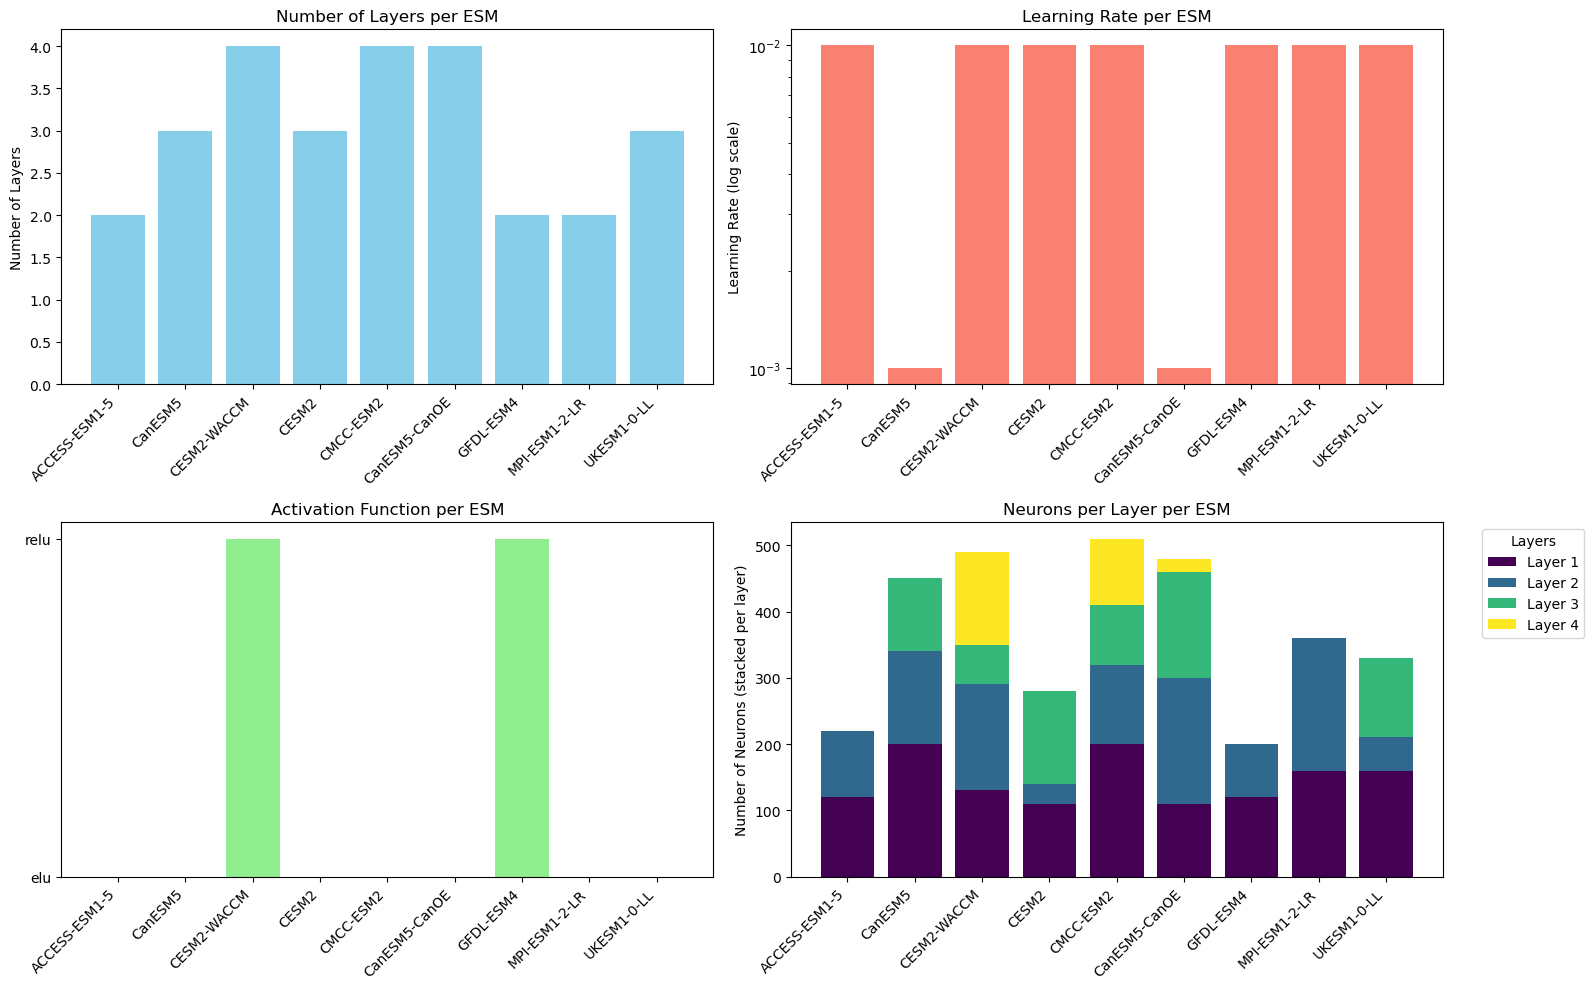

In [24]:
import os

output_dir_local = './Figures'
save_dir = os.path.join(output_dir_local, "FFN", "best hyperparameters")
os.makedirs(save_dir, exist_ok=True)

# --- Figure ---
# --- Smaller Figure ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # smaller than before
axes = axes.flatten()

# 1. Number of layers
axes[0].bar(esm_list, num_layers, color='skyblue')
axes[0].set_ylabel('Number of Layers')
axes[0].set_xticklabels(esm_list, rotation=45, ha='right')
axes[0].set_title('Number of Layers per ESM')

# 2. Learning rate
axes[1].bar(esm_list, learning_rates, color='salmon')
axes[1].set_yscale('log')
axes[1].set_ylabel('Learning Rate (log scale)')
axes[1].set_xticklabels(esm_list, rotation=45, ha='right')
axes[1].set_title('Learning Rate per ESM')

# 3. Activation function
activation_map = {act: i for i, act in enumerate(set(activations))}
activation_numeric = [activation_map[act] for act in activations]
axes[2].bar(esm_list, activation_numeric, color='lightgreen')
axes[2].set_yticks(list(activation_map.values()))
axes[2].set_yticklabels(list(activation_map.keys()))
axes[2].set_title('Activation Function per ESM')
axes[2].set_xticklabels(esm_list, rotation=45, ha='right')

# 4. Neurons per layer (stacked)
bottom = np.zeros(len(esm_list))
colors = plt.cm.viridis(np.linspace(0, 1, max_layers))
for l in range(max_layers):
    layer_units = units_array[:, l]
    layer_units = np.nan_to_num(layer_units)
    axes[3].bar(esm_list, layer_units, bottom=bottom, color=colors[l], label=f'Layer {l+1}')
    bottom += layer_units
axes[3].set_ylabel('Number of Neurons (stacked per layer)')
axes[3].set_xticklabels(esm_list, rotation=45, ha='right')
axes[3].set_title('Neurons per Layer per ESM')
axes[3].legend(title='Layers', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# --- Save figure locally ---
fig_filename = os.path.join(save_dir, "best_hyperparameters_per_ESM.png")
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"[INFO] Figure saved locally at: {fig_filename}")

plt.show()


<span style="color:lightblue; font-size:30px; font-weight:bold;">Make the Reconstructions + SOM-FFN Performance Metrics Calculation</span>

In [60]:
import fsspec
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# -------------------------------
# --- Helper functions
# -------------------------------
base_gcs_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/best_hps_per_esm/'

def build_model_from_hps(best_hps, input_shape):
    """Build FFN based on best hyperparameters."""
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_shape,)))
    model.add(layers.Normalization(name='norm_layer'))

    for i in range(best_hps['num_layers']):
        units = best_hps[f'units_{i}']
        model.add(layers.Dense(units))
        activation_function = best_hps.get('activation', 'relu')
        model.add(layers.Activation(activation_function))

    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(best_hps.get('learning_rate', 1e-3))
    )
    return model
def create_tf_datasets(X_train, y_train, X_val, y_val, batch_size=32):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(len(X_train))
    val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset   = val_dataset.prefetch(tf.data.AUTOTUNE)
    return train_dataset, val_dataset

def calculate_metrics(y_true, y_pred):
    # Remove NaNs in either array
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        return {'RMSE': np.nan, 'MAE': np.nan, 'Bias': np.nan, 'R2': np.nan}

    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = np.mean(np.abs(y_true_clean - y_pred_clean))
    bias = np.mean(y_pred_clean) - np.mean(y_true_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    return {'RMSE': rmse, 'MAE': mae, 'Bias': bias, 'R2': r2}

# -------------------------------
# --- Setup
# -------------------------------
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

# Directories
os.makedirs('./Figures', exist_ok=True)

overwrite = True

reconstructions_dir = './Reconstructions'
metrics_dir = './Metrics'
os.makedirs(reconstructions_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

metrics_per_esm = {}


# -------------------------------
# --- Main loop
# -------------------------------
for esm in esm_list:
    print(f"\n[INFO] Processing ESM: {esm}")
    metrics_per_esm[esm] = {}

    # Load split data
    split_file = f"{output_dir_base}/FFN_train_test_val_socat_{esm}.pkl"
    with fs.open(split_file, 'rb') as f:
        esm_splits = pickle.load(f)

    esm_dir = os.path.join(reconstructions_dir, esm)
    os.makedirs(esm_dir, exist_ok=True)

    for member, member_data in esm_splits.items():
        print(f"[INFO] Processing member: {member}")
        member_file = os.path.join(esm_dir, f"{member}_predictions.pkl")

        compute_predictions = True
        if os.path.exists(member_file) and not overwrite:
            compute_predictions = False
            print(f"[INFO] Predictions exist for {member}, skipping.")
        else:
            compute_predictions = True

        if compute_predictions:
            # Load original input DF for this member
            data_dir = f"{MLinputs_path_abby}/{esm}/{member}"
            fname = f"MLinput_{esm}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            with fs.open(os.path.join(data_dir, fname), 'rb') as f:
                df = pd.read_pickle(f)

            df['pCO2_testbed_truth'] = df['spco2']
            df['pCO2_recon_full'] = np.nan
            df['pCO2_recon_test'] = np.nan
            df['pCO2_recon_socat'] = np.nan 

            # Loop over provinces
            for prov, split_data in member_data['splits'].items():
                hps_file = f"{base_gcs_path}{esm}/{member}/best_hps_{esm}_{member}_{prov}.pkl"
                with fs.open(hps_file, 'rb') as f_hps:
                    best_hps = pickle.load(f_hps)

                # Prepare TF datasets
                X_train = split_data['train']['features'].drop(columns=['row_id']).to_numpy()
                y_train = split_data['train']['target'].to_numpy().flatten()
                X_val   = split_data['val']['features'].drop(columns=['row_id']).to_numpy()
                y_val   = split_data['val']['target'].to_numpy().flatten()
                X_test  = split_data['test']['features'].drop(columns=['row_id']).to_numpy()
                y_test  = split_data['test']['target'].to_numpy().flatten()
                X_socat = split_data['socat_out']['features'].drop(columns=['row_id']).to_numpy()
                y_socat = split_data['socat_out']['target'].to_numpy().flatten()

                # Build model
                model = build_model_from_hps(best_hps, X_train.shape[1])
                norm_layer = model.get_layer('norm_layer')
                norm_layer.adapt(np.vstack([X_train, X_val]))
 
                train_dataset, val_dataset = create_tf_datasets(X_train, y_train, X_val, y_val, batch_size=256)
                model.fit(train_dataset, validation_data=val_dataset, epochs=100,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                          verbose=1)

                # Predict
                y_pred_train = model.predict(X_train).flatten()
                y_pred_val   = model.predict(X_val).flatten()
                y_pred_test  = model.predict(X_test).flatten()
                y_pred_socat = model.predict(X_socat).flatten()

                assert len(y_pred_train) == len(split_data['train']['orig_row_id'])
                assert len(y_pred_val)   == len(split_data['val']['orig_row_id'])
                assert len(y_pred_test)  == len(split_data['test']['orig_row_id'])
                assert len(y_pred_socat) == len(split_data['socat_out']['orig_row_id'])
                
                # Train/Val/Test/SOCAT-out
                df.iloc[split_data['train']['orig_row_id'], df.columns.get_loc('pCO2_recon_full')] = y_pred_train
                df.iloc[split_data['val']['orig_row_id'],   df.columns.get_loc('pCO2_recon_full')] = y_pred_val
                df.iloc[split_data['test']['orig_row_id'],  df.columns.get_loc('pCO2_recon_full')] = y_pred_test
                df.iloc[split_data['socat_out']['orig_row_id'], df.columns.get_loc('pCO2_recon_full')] = y_pred_socat

                df.iloc[split_data['test']['orig_row_id'],  df.columns.get_loc('pCO2_recon_test')]  = y_pred_test
                df.iloc[split_data['socat_out']['orig_row_id'], df.columns.get_loc('pCO2_recon_socat')] = y_pred_socat

            # --- Prepare final DataFrame with only 4 columns ---
            df_results = pd.DataFrame({
                'pCO2_true': df['pCO2_testbed_truth'],
                'pCO2_full': df['pCO2_recon_full'],
                'pCO2_test': df['pCO2_recon_test'] if 'pCO2_recon_test' in df.columns else np.full(len(df), np.nan),
                'pCO2_socat': df['pCO2_recon_socat'] if 'pCO2_recon_socat' in df.columns else np.full(len(df), np.nan)
            })
            # Save only the simplified DataFrame
            print(f"[INFO] SAVING THE FILE {esm}")
            with open(member_file, 'wb') as f:
                pickle.dump(df_results, f)
            print(f"[INFO] SAVED THE FILE {esm}")

        # Load predictions
        with open(member_file, 'rb') as f:
            df_member = pickle.load(f)

        # Metrics
        metrics_member = {}

        # Test
        if 'pCO2_test' in df_member.columns:
            mask_test = ~df_member['pCO2_test'].isna()
            metrics_member['test'] = calculate_metrics(df_member['pCO2_true'][mask_test],
                                                       df_member['pCO2_test'][mask_test])
        else:
            metrics_member['test'] = {'RMSE': np.nan, 'MAE': np.nan, 'Bias': np.nan, 'R2': np.nan}

        # SOCAT
        if 'pCO2_socat' in df_member.columns:
            mask_socat = ~df_member['pCO2_socat'].isna()
            metrics_member['socat'] = calculate_metrics(df_member['pCO2_true'][mask_socat],
                                                        df_member['pCO2_socat'][mask_socat])
        else:
            metrics_member['socat'] = {'RMSE': np.nan, 'MAE': np.nan, 'Bias': np.nan, 'R2': np.nan}

        metrics_per_esm[esm][member] = metrics_member

# --- Save metrics per ESM ---
for esm, metrics_dict in metrics_per_esm.items():
    metrics_file = os.path.join(metrics_dir, f"metrics_{esm}.pkl")
    with open(metrics_file, 'wb') as f:
        pickle.dump(metrics_dict, f)
    print(f"[INFO] Saved metrics for ESM {esm}")


[INFO] Processing ESM: ACCESS-ESM1-5
[INFO] Processing member: member_r4i1p1f1
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 153507.2969 - val_loss: 149914.0781
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 146446.9062 - val_loss: 134348.7969
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 128437.0000 - val_loss: 106099.0703
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 97247.0703 - val_loss: 63363.3203
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53025.9492 - val_loss: 17358.8730
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12730.3027 - val_loss: 6267.2246
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9922.7354 - val_loss: 8962.1543
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7317.1792 - val_loss: 1576.0653
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1775.6794 - val_loss: 2591.1675
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2505.9595 - val_loss: 1504.7462
Epoch 11/10

FileNotFoundError: b/leap-persistent/o/mauriekeppens%2FEnsemble_Testbed%2F02_ML_results%2FSOMFFN%2FFFN%2FFFN_train_test_val_socat_CanESM5.pkl

In [12]:
import fsspec
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# -------------------------------
# --- Helper functions
# -------------------------------
base_gcs_path = f'gs://leap-persistent/{your_username}/Ensemble_Testbed/02_ML_results/SOMFFN/FFN/best_hps_per_esm/'

def build_model_from_hps(best_hps, input_shape):
    """Build FFN based on best hyperparameters."""
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_shape,)))
    model.add(layers.Normalization(name='norm_layer'))

    for i in range(best_hps['num_layers']):
        units = best_hps[f'units_{i}']
        model.add(layers.Dense(units))
        activation_function = best_hps.get('activation', 'relu')
        model.add(layers.Activation(activation_function))

    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(best_hps.get('learning_rate', 1e-3))
    )
    return model
def create_tf_datasets(X_train, y_train, X_val, y_val, batch_size=32):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(len(X_train))
    val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset   = val_dataset.prefetch(tf.data.AUTOTUNE)
    return train_dataset, val_dataset

def calculate_metrics(y_true, y_pred):
    # Remove NaNs in either array
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        return {'RMSE': np.nan, 'MAE': np.nan, 'Bias': np.nan, 'R2': np.nan}

    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = np.mean(np.abs(y_true_clean - y_pred_clean))
    bias = np.mean(y_pred_clean) - np.mean(y_true_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    return {'RMSE': rmse, 'MAE': mae, 'Bias': bias, 'R2': r2}

# -------------------------------
# --- Main workflow
# -------------------------------

fs = fsspec.filesystem('gs')

# Directories
os.makedirs('./Reconstructions', exist_ok=True)
os.makedirs('./Metrics', exist_ok=True)
os.makedirs('./Figures', exist_ok=True)

reconstructions_dir = './Reconstructions'
metrics_dir = './Metrics'

metrics_per_esm = {}
overwrite = True
for esm in esm_list:
    print(f"\n[INFO] Processing ESM: {esm}")
    metrics_per_esm[esm] = {}

    # --- Load split data ---
    split_file = f"{output_dir_base}/FFN_train_test_val_socat_{esm}.pkl"
    with fs.open(split_file, 'rb') as f:
        esm_splits = pickle.load(f)

    esm_dir = os.path.join(reconstructions_dir, esm)
    os.makedirs(esm_dir, exist_ok=True)

    for member, member_data in esm_splits.items():
        print(f"\n[INFO] Processing member: {member}")
        member_dir = esm_dir
        member_file = os.path.join(member_dir, f"{member}_predictions.pkl")

        if os.path.exists(member_file) and not overwrite:
            print(f"[INFO] Found existing predictions for {member}, skipping computation.")
            compute_predictions = False
        else:
            if os.path.exists(member_file) and overwrite:
                print(f"[INFO] Overwriting existing predictions for {member}.")
            compute_predictions = True

        if compute_predictions:
            # Load ML input dataframe
            data_dir = f"{MLinputs_path_abby}/{esm}/{member}"
            fname = f"MLinput_{esm}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = os.path.join(data_dir, fname)
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
            df['pCO2_testbed_truth'] = df['spco2']
            df['pCO2_recon_full']  = np.nan
            df['pCO2_recon_test']  = np.nan
            df['pCO2_recon_socat'] = np.nan

            # --- Loop over provinces ---
            for prov, split_data in member_data['splits'].items():
                print(f"Processing province: {prov}")

                # Load best hyperparameters
                hps_file = f"{base_gcs_path}{esm}/{member}/best_hps_{esm}_{member}_{prov}.pkl"
                if fs.exists(hps_file):
                    with fs.open(hps_file, 'rb') as f_hps:
                        best_hps = pickle.load(f_hps)
                else:
                    raise FileNotFoundError(f"HPS file not found: {hps_file}")

                # Prepare datasets
                X_train = split_data['train']['features'].to_numpy()
                y_train = split_data['train']['target'].to_numpy().flatten()
                X_val   = split_data['val']['features'].to_numpy()
                y_val   = split_data['val']['target'].to_numpy().flatten()
                X_test  = split_data['test']['features'].to_numpy()
                y_test  = split_data['test']['target'].to_numpy().flatten()
                X_socat = split_data['socat_out']['features'].to_numpy()
                y_socat = split_data['socat_out']['target'].to_numpy().flatten()

                # Build & normalize model
                input_shape = X_train.shape[1]
                model = build_model_from_hps(best_hps, input_shape)
                norm_layer = model.get_layer('norm_layer')
                norm_layer.adapt(np.vstack([X_train, X_val]))

                train_dataset, val_dataset = create_tf_datasets(X_train, y_train, X_val, y_val, batch_size=256)

                # Fit model
                model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=100,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                          verbose=1)

                # Predict
                y_pred_train = model.predict(X_train).flatten()
                y_pred_val   = model.predict(X_val).flatten()
                y_pred_test  = model.predict(X_test).flatten()
                y_pred_socat = model.predict(X_socat).flatten()

                # Assign predictions
                df['pCO2_recon_full']  = np.nan
                df['pCO2_recon_test']  = np.nan
                df['pCO2_recon_socat'] = np.nan

                df.iloc[split_data['train']['features'].index, df.columns.get_loc('pCO2_recon_full')] = y_pred_train
                df.iloc[split_data['val']['features'].index, df.columns.get_loc('pCO2_recon_full')] = y_pred_val
                df.iloc[split_data['test']['features'].index, df.columns.get_loc('pCO2_recon_full')] = y_pred_test
                df.iloc[split_data['socat_out']['features'].index, df.columns.get_loc('pCO2_recon_full')] = y_pred_socat

                df.iloc[split_data['test']['metadata'].index, df.columns.get_loc('pCO2_recon_test')] = y_pred_test
                df.iloc[split_data['socat_out']['metadata'].index, df.columns.get_loc('pCO2_recon_socat')] = y_pred_socat

            # Save member predictions
            with open(member_file, 'wb') as f:
                pickle.dump(df, f)
            print(f"[INFO] Saved predictions for {member}")

        # --- Compute metrics for member ---
        with open(member_file, 'rb') as f:
            df = pickle.load(f)
        
        print(f"[INFO] Running the metrics for {member}")

        metrics_member = {}
        mask_test_valid = ~np.isnan(df['pCO2_recon_test'])
        metrics_member['test'] = calculate_metrics(df['pCO2_testbed_truth'][mask_test_valid],
                                                    df['pCO2_recon_test'][mask_test_valid])
        mask_socat_valid = ~np.isnan(df['pCO2_recon_socat'])
        metrics_member['socat'] = calculate_metrics(df['pCO2_testbed_truth'][mask_socat_valid],
                                                     df['pCO2_recon_socat'][mask_socat_valid])
        metrics_per_esm[esm][member] = metrics_member

# --- Save metrics per ESM ---
for esm, metrics_dict in metrics_per_esm.items():
    metrics_file = os.path.join(metrics_dir, f"metrics_{esm}.pkl")
    with open(metrics_file, 'wb') as f:
        pickle.dump(metrics_dict, f)
    print(f"[INFO] Saved metrics for ESM {esm}")



[INFO] Processing ESM: ACCESS-ESM1-5

[INFO] Processing member: member_r4i1p1f1
[INFO] Overwriting existing predictions for member_r4i1p1f1.
Processing province: 10.0
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 153232.4531 - val_loss: 151156.1250
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 147733.7500 - val_loss: 139039.5781
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132768.4062 - val_loss: 116146.4062
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107687.6406 - val_loss: 81823.6719
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71880.1250 - val_loss: 43562.1367
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36096.1875 - val_loss: 16047.3857
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14067.3662 - val_loss: 6671.6396
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9375.5410 - val_loss: 11635.9600
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11536.4834 - val_loss: 5066.1416
Epoch 10

KeyError: "Index([ 888,  271, 1164,  880,  492,  304,  844,  796,  959, 1008,\n       ...\n       1147,  942, 1694,  935, 1199,  517,  972,  504, 1082, 1721],\n      dtype='int64', length=1275) not in index"

<span style="color:lightblue; font-size:30px; font-weight:bold;">Plot the Performance</span>

<span style="color:purple; font-size:20px; font-weight:bold;">Plot the Performance - for each ESM</span>

In [61]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Directories
reconstructions_dir = './Reconstructions'
output_dir_local = './Figures'
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Performance_per_ESM")
os.makedirs(save_dir_local, exist_ok=True)

# ESM list
esm_list = ["ACCESS-ESM1-5"] #, "CanESM5", "CESM2-WACCM", "CESM2", "CMCC-ESM2",
           # "CanESM5-CanOE", "GFDL-ESM4", "MPI-ESM1-2-LR", "UKESM1-0-LL"]

# Loop over ESMs
for esm in esm_list:
    esm_dir = os.path.join(reconstructions_dir, esm)
    member_files = sorted([f for f in os.listdir(esm_dir) if f.endswith('_predictions.pkl')])
    # Prepare figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].set_title(f"{esm} — Test Set Performance")
    axes[1].set_title(f"{esm} — No Socat Mask Set Performance")

    colors = plt.cm.tab20.colors  # 20 distinct colors (enough for 18 members)

    for j, member_file in enumerate(member_files):
        member_name = member_file.replace('_predictions.pkl', '')
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)

        # --- Test dataset ---
        y_true_test = df_member['pCO2_true'].values
        y_pred_test = df_member['pCO2_test'].values
        mask_test = ~np.isnan(y_true_test) & ~np.isnan(y_pred_test)
        r2_test = r2_score(y_true_test[mask_test], y_pred_test[mask_test])
        axes[0].scatter(y_true_test[mask_test], y_pred_test[mask_test],
                        alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2_test:.2f})")

        # --- SOCAT dataset ---
        y_true_socat = df_member['pCO2_true'].values
        y_pred_socat = df_member['pCO2_socat'].values
        mask_socat = ~np.isnan(y_true_socat) & ~np.isnan(y_pred_socat)
        r2_socat = r2_score(y_true_socat[mask_socat], y_pred_socat[mask_socat])
        axes[1].scatter(y_true_socat[mask_socat], y_pred_socat[mask_socat],
                        alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2_socat:.2f})")

    # 1:1 lines
    for ax in axes:
        all_vals = []
        for member_file in member_files:
            with open(os.path.join(esm_dir, member_file), 'rb') as f:
                df_member = pickle.load(f)
            if 'test' in ax.get_title().lower():
                y_true = df_member['pCO2_true'].values
                y_pred = df_member['pCO2_test'].values
            else:
                y_true = df_member['pCO2_true'].values
                y_pred = df_member['pCO2_socat'].values
            mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
            all_vals.extend(y_true[mask])
            all_vals.extend(y_pred[mask])
        lims = [min(all_vals), max(all_vals)]
        ax.plot(lims, lims, 'k--', lw=1)
        ax.set_xlabel("True pCO₂ (μatm)")
        ax.set_ylabel("Predicted pCO₂ (μatm)")
        ax.grid(True)

    axes[0].legend(fontsize=6, loc='upper left')
    axes[1].legend(fontsize=6, loc='upper left')
    plt.suptitle(f"{esm} — Model Predictions Across Members", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure per ESM
    plot_file = os.path.join(save_dir_local, f"{esm}_performance.png")
    plt.savefig(plot_file, dpi=300)
    plt.close()
    print(f"[INFO] Saved figure for {esm} → {plot_file}")

[INFO] Saved figure for ACCESS-ESM1-5 → ./Figures/SOMFFN/Performance_per_ESM/ACCESS-ESM1-5_performance.png


<span style="color:purple; font-size:20px; font-weight:bold;">Plot the Performance - for all ESM together</span>

In [ ]:
# Plot the test dataset performance - 9 subplots (one for each esm)

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Directory to save plots
output_dir_local = './Figures'
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Performance")
os.makedirs(save_dir_local, exist_ok=True)
reconstructions_dir = './Reconstructions'
esm_list = ["ACCESS-ESM1-5", "CanESM5", "CESM2-WACCM", "CESM2", "CMCC-ESM2",
            "CanESM5-CanOE", "GFDL-ESM4", "MPI-ESM1-2-LR", "UKESM1-0-LL"]

n_esms = len(esm_list)
cols = 3
rows = int(np.ceil(n_esms / cols))

# Test dataset figure
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.ravel()
colors = plt.cm.tab20.colors  # up to 20 colors

for i, esm in enumerate(esm_list):
    esm_dir = os.path.join(reconstructions_dir, esm)
    member_files = sorted([f for f in os.listdir(esm_dir) if f.endswith('_predictions.pkl')])
    ax = axes[i]
    ax.set_title(esm)

    for j, member_file in enumerate(member_files):
        member_name = member_file.replace('_predictions.pkl', '')
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)
        y_true = df_member['pCO2_testbed_truth'].values
        y_pred = df_member['pCO2_recon_test'].values
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        r2 = r2_score(y_true[mask], y_pred[mask])
        ax.scatter(y_true[mask], y_pred[mask],
                   alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2:.2f})")
    # 1:1 line
    all_vals = []
    for member_file in member_files:
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)
        y_true = df_member['pCO2_testbed_truth'].values
        y_pred = df_member['pCO2_recon_test'].values
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        all_vals.extend(y_true[mask])
        all_vals.extend(y_pred[mask])
    lims = [min(all_vals), max(all_vals)]
    ax.plot(lims, lims, 'k--', lw=1)

    ax.set_xlabel("True pCO₂ (μatm)")
    ax.set_ylabel("Predicted pCO₂ (μatm)")
    ax.grid(True)
    ax.legend(fontsize=6)

# Remove empty subplots if any
for k in range(n_esms, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plot_file = os.path.join(save_dir_local, "Test_set_performance_all_ESMs.png")
plt.savefig(plot_file, dpi=300)
plt.close()
print(f"[INFO] Saved Test set performance plot → {plot_file}")

In [ ]:
### Plot the SOCAT UNSEEN dataset performance - 9 subplots (one for each esm)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.ravel()
colors = plt.cm.tab20.colors  # up to 20 colors

for i, esm in enumerate(esm_list):
    esm_dir = os.path.join(reconstructions_dir, esm)
    member_files = sorted([f for f in os.listdir(esm_dir) if f.endswith('_predictions.pkl')])
    ax = axes[i]
    ax.set_title(esm)

    for j, member_file in enumerate(member_files):
        member_name = member_file.replace('_predictions.pkl', '')
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)

        y_true = df_member['pCO2_testbed_truth'].values
        y_pred = df_member['pCO2_recon_socat'].values
        r2 = r2_score(y_true[mask], y_pred[mask])
        ax.scatter(y_true[mask], y_pred[mask],
                   alpha=0.6, color=colors[j % 20], label=f"{member_name} (R²={r2:.2f})")
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        ax.scatter(y_true[mask], y_pred[mask],
                   alpha=0.6, color=colors[j % 20], label=member_name)

    # 1:1 line
    all_vals = []
    for member_file in member_files:
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            df_member = pickle.load(f)
        y_true = df_member['pCO2_testbed_truth'].values
        y_pred = df_member['pCO2_recon_socat'].values
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        all_vals.extend(y_true[mask])
        all_vals.extend(y_pred[mask])
    lims = [min(all_vals), max(all_vals)]
    ax.plot(lims, lims, 'k--', lw=1)

    ax.set_xlabel("True pCO₂ (μatm)")
    ax.set_ylabel("Predicted pCO₂ (μatm)")
    ax.grid(True)
    ax.legend(fontsize=6)

# Remove empty subplots if any
for k in range(n_esms, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plot_file_socat = os.path.join(save_dir_local, "SOCAT_set_performance_all_ESMs.png")
plt.savefig(plot_file_socat, dpi=300)
plt.close()
print(f"[INFO] Saved SOCAT set performance plot → {plot_file_socat}")

<span style="color:hotpink; font-size:40px; font-weight:bold;">Make The Figures</span>

<span style="color:hotpink; font-size:40px; font-weight:bold;">Figures Comparison LDEO XGBOOST - SOM FFN</span>

In [62]:
### Check the structure of LDEO XGBoost

import fsspec
import xarray as xr

abby_zarr_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'

import fsspec
import xarray as xr

fs = fsspec.filesystem('gs')
store = fs.get_mapper(abby_zarr_path)

ds = xr.open_zarr(store)
print(ds)
print(ds.dims)
print(ds.data_vars)

# so already 3 dims = time x lat x lon!

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 503, ylat: 180, xlon: 360)
Coordinates:
  * time               (time) datetime64[ns] 4kB 1982-02-01 ... 2023-12-01
  * xlon               (xlon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * ylat               (ylat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    pCO2_recon_full    (time, ylat, xlon) float64 261MB dask.array<chunksize=(100, 45, 90), meta=np.ndarray>
    pCO2_recon_test    (time, ylat, xlon) float64 261MB dask.array<chunksize=(100, 45, 90), meta=np.ndarray>
    pCO2_recon_train   (time, ylat, xlon) float64 261MB dask.array<chunksize=(100, 45, 90), meta=np.ndarray>
    pCO2_recon_unseen  (time, ylat, xlon) float64 261MB dask.array<chunksize=(100, 45, 90), meta=np.ndarray>
FrozenMappingWarningOnValuesAccess({'time': 503, 'ylat': 180, 'xlon': 360})
Data variables:
    pCO2_recon_full    (time, ylat, xlon) float64 261MB dask.array<chunksize=(100, 45, 90), meta=np.ndarray>
    pCO2_recon_te

In [83]:
import fsspec
import xarray as xr
import pandas as pd
import numpy as np
import os

# --- Paths ---
abby_zarr_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'
MLinputs_path_abby = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs"
esm = "ACCESS-ESM1-5"
member = "member_r5i1p1f1"
init_date = "198202"
fin_date = "202312"

# --- Load ML-input pickle (true pCO2) ---
fs = fsspec.filesystem('gs')
data_dir = f"{MLinputs_path_abby}/{esm}/{member}"
fname = f"MLinput_{esm}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"

with fs.open(os.path.join(data_dir, fname), 'rb') as f:
    df = pd.read_pickle(f)

# Define truth
df['pCO2_testbed_truth'] = df['spco2']

# Flatten → back to columns
df = df.reset_index()

# Convert back to 3D xarray
ds_truth = (
    df.set_index(['time', 'ylat', 'xlon'])['pCO2_testbed_truth']
      .to_xarray()
)

print(ds_truth)
print(f"[INFO] Truth shape: {ds_truth.shape}")

# --- Load LDEO XGBoost reconstruction ---
store = fs.get_mapper(abby_zarr_path)
ds = xr.open_zarr(store)
pco2_recon_full = ds['pCO2_recon_full']  # (time, ylat, xlon)

print(ds)
print(f"[INFO] LDEO pCO2 shape: {pco2_recon_full.shape}")

# --- Compare at one time step ---
time_idx = 0  # eerste maand
time_val = ds.time[time_idx].values

# Select truth for this time (already 2D)
y_true = ds_truth.isel(time=time_idx).values.ravel()
y_pred = pco2_recon_full.isel(time=time_idx).values.ravel()

# Error statistics
error = y_pred - y_true
print(f"Global error stats for time {time_val}:")
print(f"Mean: {np.nanmean(error):.2f}")
print(f"Std: {np.nanstd(error):.2f}")
print(f"Min: {np.nanmin(error):.2f}")
print(f"Max: {np.nanmax(error):.2f}")

<xarray.DataArray 'pCO2_testbed_truth' (time: 503, ylat: 180, xlon: 360)> Size: 261MB
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [273.81048007, 273.70819009, 273.60608835, ..., 274.11906301,
         274.01571888, 273.91299594],
        [274.56099564, 274.48552995, 274.41032781, ..., 274.78872921,
         274.71258586, 274.63668722],
        [275.4051233 , 275.37498596, 275.34501805, ..., 275.49626943,
         275.46575562, 275.43537357]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan

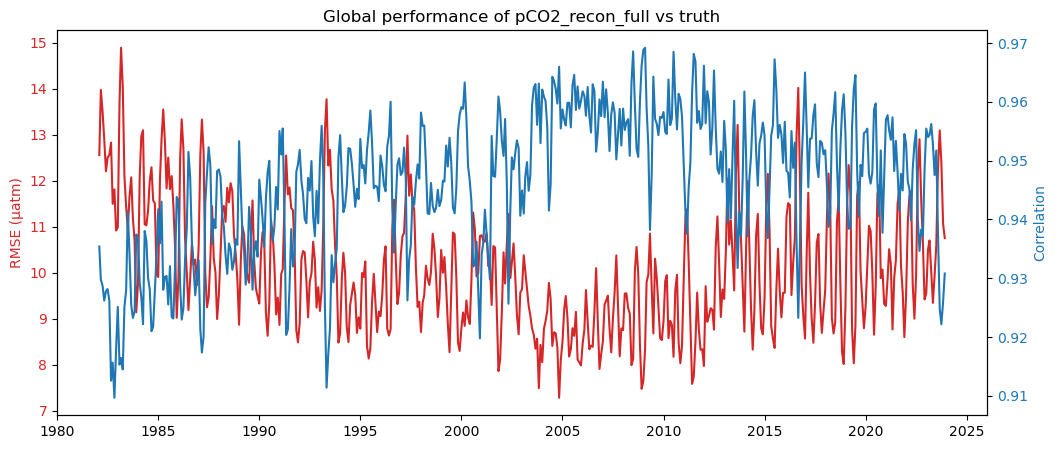

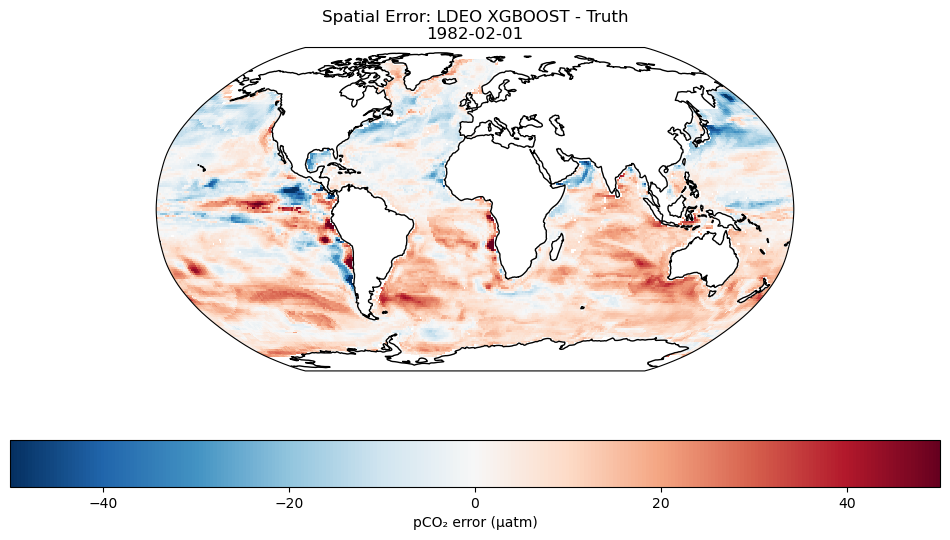

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import os

# --- Bereken metrics over alle maanden ---
rmse_list = []
corr_list = []
time_list = []

for t in range(len(ds.time)):
    y_true = ds_truth.isel(time=t).values.ravel()
    y_pred = pco2_recon_full.isel(time=t).values.ravel()

    # Mask NaN (bijv. land)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        rmse_list.append(np.nan)
        corr_list.append(np.nan)
    else:
        rmse = np.sqrt(np.mean((y_pred[mask] - y_true[mask])**2))
        corr = np.corrcoef(y_true[mask], y_pred[mask])[0,1]
        rmse_list.append(rmse)
        corr_list.append(corr)

    time_list.append(pd.to_datetime(ds.time.values[t]))

# --- Maak dataframe ---
metrics_df = pd.DataFrame({
    'time': time_list,
    'RMSE': rmse_list,
    'Corr': corr_list
})

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(metrics_df['time'], metrics_df['RMSE'], label='RMSE', color='tab:red')
ax1.set_ylabel('RMSE (µatm)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(metrics_df['time'], metrics_df['Corr'], label='Correlation', color='tab:blue')
ax2.set_ylabel('Correlation', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title("Global performance of pCO2_recon_full vs truth")
plt.show()

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# --- Kies een maand ---
time_idx = 0  # eerste maand (1982-02)
time_val = str(ds.time.values[time_idx])[:10]

# Selecteer velden
y_true_grid = ds_truth.isel(time=time_idx).values
y_pred_grid = pco2_recon_full.isel(time=time_idx).values
err_grid = y_pred_grid - y_true_grid  # verschil

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw={"projection": ccrs.Robinson()})

im = ax.pcolormesh(ds.xlon, ds.ylat, err_grid,
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', vmin=-50, vmax=50, shading='auto')

ax.coastlines()
ax.set_title(f"Spatial Error: LDEO XGBOOST - Truth\n{time_val}")
plt.colorbar(im, ax=ax, orientation='horizontal', label='pCO₂ error (µatm)')
plt.show()


/tmp/ipykernel_468/3567161288.py:47: RuntimeWarning: Mean of empty slice
  mean_error_grid = np.nanmean(all_errors_grid, axis=(0,1))  # (lat, lon)


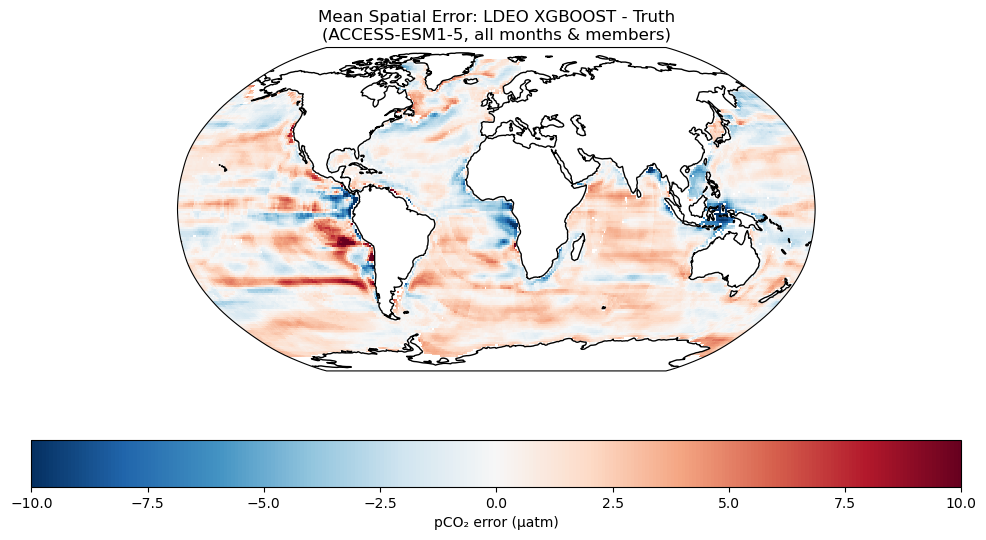

KeyError: 'pCO2_full'

In [93]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import fsspec
import pandas as pd
import os

# --- Paths ---
abby_zarr_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'
MLinputs_path_abby = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post01_xgb_inputs"
esm = "ACCESS-ESM1-5"
members = ["member_r4i1p1f1", "member_r5i1p1f1"]

# --- Load LDEO XGBOOST ---
fs = fsspec.filesystem('gs')
store = fs.get_mapper(abby_zarr_path)
ds = xr.open_zarr(store)
pco2_recon_full = ds['pCO2_recon_full'].values  # (time, lat, lon)
lat_vals = ds.ylat.values
lon_vals = ds.xlon.values
n_time, n_lat, n_lon = pco2_recon_full.shape

# --- Initialize array for errors ---
all_errors_grid = []  # list of (time, lat, lon)

for member in members:
    # Load ML-input truth
    data_dir = f"{MLinputs_path_abby}/{esm}/{member}"
    fname = f"MLinput_{esm}_{member.split('_')[-1]}_mon_1x1_198202_202312.pkl"
    with fs.open(os.path.join(data_dir, fname), 'rb') as f:
        df = pd.read_pickle(f)
    df = df.reset_index()
    df['pCO2_testbed_truth'] = df['spco2']

    # Reshape truth to (time, lat, lon)
    truth_grid = df['pCO2_testbed_truth'].values.reshape(n_time, n_lon, n_lat).transpose(0,2,1)

    # Compute error grid
    err_grid = pco2_recon_full - truth_grid
    all_errors_grid.append(err_grid)

# --- Convert list to array (members, time, lat, lon) ---
all_errors_grid = np.stack(all_errors_grid, axis=0)

# --- Mean over members and time ---
mean_error_grid = np.nanmean(all_errors_grid, axis=(0,1))  # (lat, lon)

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw={"projection": ccrs.Robinson()})
im = ax.pcolormesh(lon_vals, lat_vals, mean_error_grid,
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', vmin=-10, vmax=10, shading='auto')
ax.coastlines()
ax.set_title(f"Mean Spatial Error: LDEO XGBOOST - Truth\n({esm}, all months & members)")
plt.colorbar(im, ax=ax, orientation='horizontal', label='pCO₂ error (µatm)')
plt.show()

# --- Initialize array for SOM-FFN errors ---
all_errors_SOMFFN = []  # list of (time, lat, lon)

for member in members:
    # Load ML-input truth
    data_dir = f"{MLinputs_path_abby}/{esm}/{member}"
    fname = f"MLinput_{esm}_{member.split('_')[-1]}_mon_1x1_198202_202312.pkl"
    with fs.open(os.path.join(data_dir, fname), 'rb') as f:
        df = pd.read_pickle(f)
    df = df.reset_index()
    df['pCO2_testbed_truth'] = df['spco2']

    # Load SOM-FFN predictions
    # Assume SOM-FFN predictions are stored in 'pCO2_SOMFFN' column in the same df
    df['pCO2_SOMFFN'] = df['pCO2_full']  # adapt if your column is named differently

    # Reshape truth and SOM-FFN prediction to (time, lat, lon)
    truth_grid = df['pCO2_testbed_truth'].values.reshape(n_time, n_lon, n_lat).transpose(0,2,1)
    pred_grid  = df['pCO2_SOMFFN'].values.reshape(n_time, n_lon, n_lat).transpose(0,2,1)

    # Compute error grid
    err_grid = pred_grid - truth_grid
    all_errors_SOMFFN.append(err_grid)

# --- Convert list to array (members, time, lat, lon) ---
all_errors_SOMFFN = np.stack(all_errors_SOMFFN, axis=0)

# --- Mean over members and time ---
mean_error_SOMFFN = np.nanmean(all_errors_SOMFFN, axis=(0,1))  # (lat, lon)

# --- Plot SOM-FFN mean spatial error ---
fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw={"projection": ccrs.Robinson()})
im = ax.pcolormesh(lon_vals, lat_vals, mean_error_SOMFFN,
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', vmin=-10, vmax=10, shading='auto')
ax.coastlines()
ax.set_title(f"Mean Spatial Error: SOM-FFN - Truth\n({esm}, all months & members)")
plt.colorbar(im, ax=ax, orientation='horizontal', label='pCO₂ error (µatm)')
plt.show()


In [72]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import fsspec

# --- Define output directory ---
if output_dir_local is None:
    output_dir_local = "./Figures"
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Comparison_LDEO_XGBOOST", "Spatial_mean_errors")
os.makedirs(save_dir_local, exist_ok=True)

# --- Grid definitions ---
lat_vals = np.linspace(-89.5, 89.5, 180)
lon_vals = np.linspace(-179.5, 179.5, 360)

def reshape_flat(flat_array, n_time=503, n_lat=180, n_lon=360):
    """
    Reshape a flat array into (time, lat, lon).
    flat_array: 1D array of length n_time*n_lat*n_lon
    n_time, n_lat, n_lon: grid dimensions
    """
    reshaped = flat_array.reshape(n_time, n_lon, n_lat).transpose(0, 2, 1)
    return reshaped


# --- Load LDEO-XGBOOST file for one member to get shape and coords ---
LDEO_zarr_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'

fs = fsspec.filesystem('gs')
store = fs.get_mapper(LDEO_zarr_path)
LDEO_data = xr.open_zarr(store)

LDEO_pCO2 = LDEO_data['pCO2_recon_full'].values  # shape: (time, lat, lon)
n_time, n_lat, n_lon = LDEO_pCO2.shape

esm = "ACCESS-ESM1-5"
esm_dir = f"./Reconstructions/{esm}"
esm_file_path = f"./Reconstructions/{esm}_reconstructions.pkl"

# Als het gecombineerde bestand nog niet bestaat, maak het aan
if not os.path.exists(esm_file_path):
    reconstructions_per_esm = {}
    for member_file in os.listdir(esm_dir):
        if member_file.endswith("_predictions.pkl"):
            member_name = member_file.replace("_predictions.pkl", "")
            with open(os.path.join(esm_dir, member_file), 'rb') as f:
                reconstructions_per_esm[member_name] = pickle.load(f)
    # Sla het gecombineerde bestand op
    with open(esm_file_path, 'wb') as f:
        pickle.dump(reconstructions_per_esm, f)
    print(f"[INFO] Saved combined ESM reconstructions → {esm_file_path}")

    with open(esm_file_path, 'rb') as f:
        reconstructions_per_esm = pickle.load(f)  # dict of members

    esm_member_errors_SOMFFN = []
    esm_member_errors_LDEO = []

    for member, df in reconstructions_per_esm.items():
        # Flattened truth & SOM-FFN predictions
        y_true_flat = df['pCO2_true'].values
        y_pred_flat = df['pCO2_full'].values

        err_SOMFFN = y_pred_flat - y_true_flat
        esm_member_errors_SOMFFN.append(err_SOMFFN)

        # LDEO predictions
        LDEO_pred_flat = LDEO_pCO2.ravel()[:len(df)]  # match df length
        err_LDEO = LDEO_pred_flat - y_true_flat
        esm_member_errors_LDEO.append(err_LDEO)

    # --- Average over members ---
    esm_err_SOMFFN = np.nanmean(np.stack(esm_member_errors_SOMFFN, axis=0), axis=0)
    esm_err_LDEO = np.nanmean(np.stack(esm_member_errors_LDEO, axis=0), axis=0)

    # --- Reshape to grid ---
    esm_err_SOMFFN_grid = reshape_flat(esm_err_SOMFFN)
    esm_err_LDEO_grid = reshape_flat(esm_err_LDEO)

    # --- Take temporal mean ---
    esm_err_SOMFFN_mean = np.nanmean(esm_err_SOMFFN_grid, axis=0)
    esm_err_LDEO_mean = np.nanmean(esm_err_LDEO_grid, axis=0)

    # --- Plot spatial comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(18,6), subplot_kw={"projection": ccrs.Robinson()})
    for ax, err_grid, label in zip(axes, [esm_err_SOMFFN_mean, esm_err_LDEO_mean], ['SOM-FFN', 'LDEO XGBOOST']):
        im = ax.pcolormesh(lon_vals, lat_vals, err_grid, transform=ccrs.PlateCarree(),
                           cmap='RdBu_r', vmin=-5, vmax=5, shading='auto')
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_title(f"{label}")

    plt.colorbar(im, ax=axes, orientation='horizontal', label='pCO2 error (μatm)')
    plt.suptitle(f"{esm} — Mean (in time and members) Spatial Error Comparison")

    # --- Save figure ---
    fig_name = f"{esm}_spatial_mean_error_comparison.png"
    fig_path = os.path.join(save_dir_local, fig_name)
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # free memory

    # --- Free memory ---
    del reconstructions_per_esm

In [75]:
import os
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import fsspec

# --- Define output directory ---
output_dir_local = "./Figures"  # fallback if not defined
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Comparison_LDEO_XGBOOST", "Spatial_mean_errors")
os.makedirs(save_dir_local, exist_ok=True)
print(f"[INFO] Figures will be saved to: {save_dir_local}")

# --- Grid definitions ---
lat_vals = np.linspace(-89.5, 89.5, 180)
lon_vals = np.linspace(-179.5, 179.5, 360)
print(f"[INFO] Latitude shape: {lat_vals.shape}, Longitude shape: {lon_vals.shape}")

def reshape_flat(flat_array, n_time=503, n_lat=180, n_lon=360):
    """Reshape flat array to (time, lat, lon)"""
    reshaped = flat_array.reshape(n_time, n_lat, n_lon)#.transpose(0, 2, 1)
    return reshaped

# --- Load LDEO-XGBOOST file ---
LDEO_zarr_path = (
    'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/'
    'post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/'
    'member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'
)
print(f"[INFO] Loading LDEO data from Zarr: {LDEO_zarr_path}")
fs = fsspec.filesystem('gs')
store = fs.get_mapper(LDEO_zarr_path)
LDEO_data = xr.open_zarr(store)
LDEO_pCO2 = LDEO_data['pCO2_recon_full'].values
n_time, n_lat, n_lon = LDEO_pCO2.shape
print(f"[INFO] LDEO pCO2 shape: time={n_time}, lat={n_lat}, lon={n_lon}")

# --- ESM reconstructions ---
esm = "ACCESS-ESM1-5"
esm_dir = f"./Reconstructions/{esm}"
esm_file_path = f"./Reconstructions/{esm}_reconstructions.pkl"

# --- Debug: check if directory exists ---
if not os.path.exists(esm_dir):
    print(f"[ERROR] Directory does not exist: {esm_dir}")
else:
    dir_files = os.listdir(esm_dir)
    print(f"[INFO] Directory exists: {esm_dir}, contains {len(dir_files)} files")
    print(f"[DEBUG] First 10 files: {dir_files[:10]}")

# --- Check if combined pickle exists ---
if os.path.exists(esm_file_path):
    print(f"[INFO] Using existing combined ESM pickle: {esm_file_path}")
    with open(esm_file_path, 'rb') as f:
        reconstructions_per_esm = pickle.load(f)
    print(f"[INFO] Loaded reconstructions for {len(reconstructions_per_esm)} members")
else:
    print(f"[INFO] Combined pickle does NOT exist. Creating new one...")
    reconstructions_per_esm = {}
    member_files = [f for f in dir_files if f.endswith("_predictions.pkl")]
    print(f"[INFO] Found {len(member_files)} member files ending with '_predictions.pkl'")

    for member_file in member_files:
        member_name = member_file.replace("_predictions.pkl", "")
        try:
            with open(os.path.join(esm_dir, member_file), 'rb') as f:
                reconstructions_per_esm[member_name] = pickle.load(f)
            print(f"[INFO] Successfully loaded member: {member_name}")
        except Exception as e:
            print(f"[ERROR] Failed to load {member_file}: {e}")

    # --- Save combined pickle ---
    try:
        with open(esm_file_path, 'wb') as f:
            pickle.dump(reconstructions_per_esm, f)
        print(f"[INFO] Saved combined ESM reconstructions → {esm_file_path}")
    except Exception as e:
        print(f"[ERROR] Failed to save combined pickle: {e}")

# --- Compute errors per member ---
esm_member_errors_SOMFFN = []
esm_member_errors_LDEO = []

for member, df in reconstructions_per_esm.items():
    print(f"[INFO] Processing member: {member}")
    try:
        y_true_flat = df['pCO2_true'].values
        y_pred_flat = df['pCO2_full'].values

        err_SOMFFN = y_pred_flat - y_true_flat
        esm_member_errors_SOMFFN.append(err_SOMFFN)
        print(f"[INFO] {member} SOM-FFN error stats: mean={np.nanmean(err_SOMFFN):.2f}, std={np.nanstd(err_SOMFFN):.2f}")

        LDEO_pred_flat = LDEO_pCO2.ravel()[:len(df)]
        err_LDEO = LDEO_pred_flat - y_true_flat
        esm_member_errors_LDEO.append(err_LDEO)
        print(f"[INFO] {member} LDEO error stats: mean={np.nanmean(err_LDEO):.2f}, std={np.nanstd(err_LDEO):.2f}")
    except Exception as e:
        print(f"[ERROR] Failed processing member {member}: {e}")

# --- Average over members ---
esm_err_SOMFFN = np.nanmean(np.stack(esm_member_errors_SOMFFN, axis=0), axis=0)
esm_err_LDEO = np.nanmean(np.stack(esm_member_errors_LDEO, axis=0), axis=0)
print(f"[INFO] Average SOM-FFN error: mean={np.nanmean(esm_err_SOMFFN):.2f}, std={np.nanstd(esm_err_SOMFFN):.2f}")
print(f"[INFO] Average LDEO error: mean={np.nanmean(esm_err_LDEO):.2f}, std={np.nanstd(esm_err_LDEO):.2f}")

# --- Reshape to grid ---
esm_err_SOMFFN_grid = reshape_flat(esm_err_SOMFFN)
esm_err_LDEO_grid = reshape_flat(esm_err_LDEO)
print(f"[INFO] SOM-FFN grid shape: {esm_err_SOMFFN_grid.shape}")
print(f"[INFO] LDEO grid shape: {esm_err_LDEO_grid.shape}")

# --- Temporal mean ---
esm_err_SOMFFN_mean = np.nanmean(esm_err_SOMFFN_grid, axis=0)
esm_err_LDEO_mean = np.nanmean(esm_err_LDEO_grid, axis=0)
print(f"[INFO] Temporal mean SOM-FFN error: mean={np.nanmean(esm_err_SOMFFN_mean):.2f}")
print(f"[INFO] Temporal mean LDEO error: mean={np.nanmean(esm_err_LDEO_mean):.2f}")

# --- Plot spatial comparison ---
fig, axes = plt.subplots(1, 2, figsize=(18,6), subplot_kw={"projection": ccrs.Robinson()})
for ax, err_grid, label in zip(axes, [esm_err_SOMFFN_mean, esm_err_LDEO_mean], ['SOM-FFN', 'LDEO XGBOOST']):
    im = ax.pcolormesh(lon_vals, lat_vals, err_grid, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r', vmin=-5, vmax=5, shading='auto')
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_title(f"{label}")

plt.colorbar(im, ax=axes, orientation='horizontal', label='pCO2 error (μatm)')
plt.suptitle(f"{esm} — Mean (in time and members) Spatial Error Comparison")


# --- Save figure ---
fig_name = f"{esm}_spatial_mean_error_comparison.png"
fig_path = os.path.join(save_dir_local, fig_name)
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f"[INFO] Figure saved → {fig_path}")

# --- Free memory ---
del reconstructions_per_esm
print("[INFO] Finished processing all members and freed memory.")

[INFO] Figures will be saved to: ./Figures/SOMFFN/Comparison_LDEO_XGBOOST/Spatial_mean_errors
[INFO] Latitude shape: (180,), Longitude shape: (360,)
[INFO] Loading LDEO data from Zarr: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr
[INFO] LDEO pCO2 shape: time=503, lat=180, lon=360
[INFO] Directory exists: ./Reconstructions/ACCESS-ESM1-5, contains 2 files
[DEBUG] First 10 files: ['member_r4i1p1f1_predictions.pkl', 'member_r5i1p1f1_predictions.pkl']
[INFO] Using existing combined ESM pickle: ./Reconstructions/ACCESS-ESM1-5_reconstructions.pkl
[INFO] Loaded reconstructions for 2 members
[INFO] Processing member: member_r4i1p1f1
[INFO] member_r4i1p1f1 SOM-FFN error stats: mean=3.02, std=23.71
[INFO] member_r4i1p1f1 LDEO error stats: mean=11.30, std=54.30
[INFO] Processing member: member_r5i1p1f1
[INFO] member_r5i1p1f1 SOM-FFN error stats: mean=

/tmp/ipykernel_468/2180483139.py:104: RuntimeWarning: Mean of empty slice
  esm_err_SOMFFN = np.nanmean(np.stack(esm_member_errors_SOMFFN, axis=0), axis=0)
/tmp/ipykernel_468/2180483139.py:105: RuntimeWarning: Mean of empty slice
  esm_err_LDEO = np.nanmean(np.stack(esm_member_errors_LDEO, axis=0), axis=0)


[INFO] Average SOM-FFN error: mean=2.46, std=21.49
[INFO] Average LDEO error: mean=11.18, std=53.39
[INFO] SOM-FFN grid shape: (503, 180, 360)
[INFO] LDEO grid shape: (503, 180, 360)


/tmp/ipykernel_468/2180483139.py:116: RuntimeWarning: Mean of empty slice
  esm_err_SOMFFN_mean = np.nanmean(esm_err_SOMFFN_grid, axis=0)
/tmp/ipykernel_468/2180483139.py:117: RuntimeWarning: Mean of empty slice
  esm_err_LDEO_mean = np.nanmean(esm_err_LDEO_grid, axis=0)


[INFO] Temporal mean SOM-FFN error: mean=2.46
[INFO] Temporal mean LDEO error: mean=11.18
[INFO] Figure saved → ./Figures/SOMFFN/Comparison_LDEO_XGBOOST/Spatial_mean_errors/ACCESS-ESM1-5_spatial_mean_error_comparison.png
[INFO] Finished processing all members and freed memory.


In [73]:
import os
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import fsspec

# --- Define output directory ---
if output_dir_local is None:
    output_dir_local = "./Figures"
save_dir_local = os.path.join(output_dir_local, "SOMFFN", "Comparison_LDEO_XGBOOST", "Spatial_mean_errors")
os.makedirs(save_dir_local, exist_ok=True)
print(f"[INFO] Figures will be saved to: {save_dir_local}")

# --- Grid definitions ---
lat_vals = np.linspace(-89.5, 89.5, 180)
lon_vals = np.linspace(-179.5, 179.5, 360)
print(f"[INFO] Latitude shape: {lat_vals.shape}, Longitude shape: {lon_vals.shape}")

def reshape_flat(flat_array, n_time=503, n_lat=180, n_lon=360):
    reshaped = flat_array.reshape(n_time, n_lon, n_lat).transpose(0, 2, 1)
    return reshaped

# --- Load LDEO-XGBOOST file for one member to get shape and coords ---
LDEO_zarr_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2023/post02_1982-2023_outputs/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_198202_202312.zarr'

fs = fsspec.filesystem('gs')
store = fs.get_mapper(LDEO_zarr_path)
LDEO_data = xr.open_zarr(store)

LDEO_pCO2 = LDEO_data['pCO2_recon_full'].values  # shape: (time, lat, lon)
n_time, n_lat, n_lon = LDEO_pCO2.shape
print(f"[INFO] LDEO pCO2 shape: time={n_time}, lat={n_lat}, lon={n_lon}")

esm = "ACCESS-ESM1-5"
esm_dir = f"./Reconstructions/{esm}"
esm_file_path = f"./Reconstructions/{esm}_reconstructions.pkl"

# Als het gecombineerde bestand nog niet bestaat, maak het aan
if not os.path.exists(esm_file_path):
    reconstructions_per_esm = {}
    member_files = [f for f in os.listdir(esm_dir) if f.endswith("_predictions.pkl")]
    print(f"[INFO] Found {len(member_files)} member files in {esm_dir}")

    for member_file in member_files:
        member_name = member_file.replace("_predictions.pkl", "")
        with open(os.path.join(esm_dir, member_file), 'rb') as f:
            reconstructions_per_esm[member_name] = pickle.load(f)
        print(f"[INFO] Loaded member: {member_name}, shape: {reconstructions_per_esm[member_name].shape if hasattr(reconstructions_per_esm[member_name], 'shape') else 'N/A'}")

    # Sla het gecombineerde bestand op
    with open(esm_file_path, 'wb') as f:
        pickle.dump(reconstructions_per_esm, f)
    print(f"[INFO] Saved combined ESM reconstructions → {esm_file_path}")

    with open(esm_file_path, 'rb') as f:
        reconstructions_per_esm = pickle.load(f)  # dict of members

    esm_member_errors_SOMFFN = []
    esm_member_errors_LDEO = []

    for member, df in reconstructions_per_esm.items():
        y_true_flat = df['pCO2_true'].values
        y_pred_flat = df['pCO2_full'].values

        err_SOMFFN = y_pred_flat - y_true_flat
        esm_member_errors_SOMFFN.append(err_SOMFFN)
        print(f"[INFO] {member} SOM-FFN error: mean={np.nanmean(err_SOMFFN):.2f}, std={np.nanstd(err_SOMFFN):.2f}, min={np.nanmin(err_SOMFFN):.2f}, max={np.nanmax(err_SOMFFN):.2f}")

        LDEO_pred_flat = LDEO_pCO2.ravel()[:len(df)]
        err_LDEO = LDEO_pred_flat - y_true_flat
        esm_member_errors_LDEO.append(err_LDEO)
        print(f"[INFO] {member} LDEO error: mean={np.nanmean(err_LDEO):.2f}, std={np.nanstd(err_LDEO):.2f}, min={np.nanmin(err_LDEO):.2f}, max={np.nanmax(err_LDEO):.2f}")

    # --- Average over members ---
    esm_err_SOMFFN = np.nanmean(np.stack(esm_member_errors_SOMFFN, axis=0), axis=0)
    esm_err_LDEO = np.nanmean(np.stack(esm_member_errors_LDEO, axis=0), axis=0)
    print(f"[INFO] Average SOM-FFN error: mean={np.nanmean(esm_err_SOMFFN):.2f}, std={np.nanstd(esm_err_SOMFFN):.2f}")
    print(f"[INFO] Average LDEO error: mean={np.nanmean(esm_err_LDEO):.2f}, std={np.nanstd(esm_err_LDEO):.2f}")

    # --- Reshape to grid ---
    esm_err_SOMFFN_grid = reshape_flat(esm_err_SOMFFN)
    esm_err_LDEO_grid = reshape_flat(esm_err_LDEO)
    print(f"[INFO] SOM-FFN grid shape: {esm_err_SOMFFN_grid.shape}")
    print(f"[INFO] LDEO grid shape: {esm_err_LDEO_grid.shape}")

    # --- Take temporal mean ---
    esm_err_SOMFFN_mean = np.nanmean(esm_err_SOMFFN_grid, axis=0)
    esm_err_LDEO_mean = np.nanmean(esm_err_LDEO_grid, axis=0)
    print(f"[INFO] Temporal mean SOM-FFN error: mean={np.nanmean(esm_err_SOMFFN_mean):.2f}")
    print(f"[INFO] Temporal mean LDEO error: mean={np.nanmean(esm_err_LDEO_mean):.2f}")

    # --- Plot spatial comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(18,6), subplot_kw={"projection": ccrs.Robinson()})
    for ax, err_grid, label in zip(axes, [esm_err_SOMFFN_mean, esm_err_LDEO_mean], ['SOM-FFN', 'LDEO XGBOOST']):
        im = ax.pcolormesh(lon_vals, lat_vals, err_grid, transform=ccrs.PlateCarree(),
                           cmap='RdBu_r', vmin=-5, vmax=5, shading='auto')
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_title(f"{label}")

    plt.colorbar(im, ax=axes, orientation='horizontal', label='pCO2 error (μatm)')
    plt.suptitle(f"{esm} — Mean (in time and members) Spatial Error Comparison")

    # --- Save figure ---
    fig_name = f"{esm}_spatial_mean_error_comparison.png"
    fig_path = os.path.join(save_dir_local, fig_name)
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"[INFO] Figure saved → {fig_path}")

    # --- Free memory ---
    del reconstructions_per_esm


[INFO] Figures will be saved to: ./Figures/SOMFFN/Comparison_LDEO_XGBOOST/Spatial_mean_errors
[INFO] Latitude shape: (180,), Longitude shape: (360,)
[INFO] LDEO pCO2 shape: time=503, lat=180, lon=360


In [67]:
fs.ls(f'gs://leap-persistent/mauriekeppens/Ensemble_Testbed')

['leap-persistent/mauriekeppens/Ensemble_Testbed/00_regridded_members',
 'leap-persistent/mauriekeppens/Ensemble_Testbed/01_ML_inputs',
 'leap-persistent/mauriekeppens/Ensemble_Testbed/02_ML_results']